<a href="https://colab.research.google.com/github/sararosengithub/Wepan_presentation_analysis/blob/main/Weapon_Presentation_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import csv
from pprint import pprint
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import os
from io import StringIO
import seaborn as sns
from sklearn.metrics import r2_score

In [ ]:
relative_path = "/content/drive/MyDrive/Weapon_presentation/"

In [51]:
def parse_event_file(file_path):
    """
    Parses an event file with dynamic headers.

    Args:
        file_path (str): The path to the .event file.

    Returns:
        tuple: (header_definitions, events_data)
               header_definitions (dict): A dictionary mapping (category, event_type)
                                          tuples to a list of their field names.
               events_data (list): A list of dictionaries, where each dictionary
                                   represents an event with its parsed fields.
    """
    header_definitions = {}
    events_data = []

    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        for row_parts in reader:
            if not row_parts:
                continue

            if row_parts[0] == "HEADER":
                category = row_parts[1]
                event_sub_type = row_parts[2]
                field_names = row_parts[3:]
                header_definitions[(category, event_sub_type)] = field_names
            else:
                timestamp = int(row_parts[0])
                category = row_parts[1]
                event_sub_type = row_parts[2]
                values = row_parts[3:]

                event_record = {
                    "timestamp": timestamp,
                    "category": category,
                    "event_type": event_sub_type
                }

                # Get the field names for this event type
                field_names = header_definitions.get((category, event_sub_type))

                if field_names:
                    if len(values) == len(field_names):
                        for i, field_name in enumerate(field_names):
                            event_record[field_name] = values[i]
                    else:
                        print(f"Warning: Mismatch in field count for event {category}/{event_sub_type} at timestamp {timestamp}.")
                        print(f"  Expected {len(field_names)} fields ({field_names}), got {len(values)} ({values}).")
                        for i, field_name in enumerate(field_names):
                            if i < len(values):
                                event_record[field_name] = values[i]
                            else:
                                event_record[field_name] = None
                else:
                    print(f"Warning: No header definition found for event {category}/{event_sub_type} at timestamp {timestamp}.")
                    event_record['raw_values'] = values

                events_data.append(event_record)

    return header_definitions, events_data

In [52]:
def plot_drill_presentation(scenario_id, drill_uid, trajectory_df, T_pres_start, T_pres_end, weapon_pos_cols, curve_type,curve_fit_polynomial, base_output_dir="plots"):
    """
    Creates and saves a 2D plot (XZ and YZ views) of the weapon presentation path.
    """
    if trajectory_df.empty or len(trajectory_df) < 2:
        print(f"  Plotting: No trajectory data to plot for drill {drill_uid}.")
        return

    # Create scenario-specific output directory
    output_dir = os.path.join(base_output_dir, f"scenario_{scenario_id}")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # Ensure weapon position columns are numeric
    for col in weapon_pos_cols:
        trajectory_df[col] = pd.to_numeric(trajectory_df[col], errors='coerce')
    trajectory_df = trajectory_df.dropna(subset=weapon_pos_cols)

    if trajectory_df.empty or len(trajectory_df) < 2:
        print(f"  Plotting: Not enough valid numeric trajectory data after conversion for drill {drill_uid}.")
        return

    x_col, y_col, z_col = weapon_pos_cols[0], weapon_pos_cols[1], weapon_pos_cols[2]

    path_x = trajectory_df[x_col]
    path_y = trajectory_df[y_col]
    path_z = trajectory_df[z_col]


    start_point_data = trajectory_df[trajectory_df['timestamp'] == T_pres_start]
    end_point_data = trajectory_df[trajectory_df['timestamp'] == T_pres_end]

    start_x, start_y, start_z = None, None, None
    if not start_point_data.empty:
        start_x = start_point_data[x_col].iloc[0]
        start_y = start_point_data[y_col].iloc[0]
        start_z = start_point_data[z_col].iloc[0]
    elif not trajectory_df.empty: # Fallback to first point of trajectory if exact timestamp match fails
        start_x, start_y, start_z = path_x.iloc[0], path_y.iloc[0], path_z.iloc[0]


    end_x, end_y, end_z = None, None, None
    if not end_point_data.empty:
        end_x = end_point_data[x_col].iloc[0]
        end_y = end_point_data[y_col].iloc[0]
        end_z = end_point_data[z_col].iloc[0]
    elif not trajectory_df.empty: # Fallback to last point
        end_x, end_y, end_z = path_x.iloc[-1], path_y.iloc[-1], path_z.iloc[-1]


    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f"Drill: {drill_uid} - Presentation Path (Curve type: {curve_type}, Curve type fit to parabolic: {curve_fit_polynomial})", fontsize=16)

    # Top-Down View (XZ plane)
    axs[0].plot(path_x, path_z, marker='.', linestyle='-', label="Path")
    if start_x is not None:
        axs[0].plot(start_x, start_z, 'go', markersize=10, label="Start (T_pres_start)")
    if end_x is not None:
        axs[0].plot(end_x, end_z, 'ro', markersize=10, label="End (T_pres_end)")
    axs[0].set_xlabel("X-coordinate (meters)")
    axs[0].set_ylabel("Z-coordinate (meters, Forward)")
    axs[0].set_title("Top-Down View (XZ Plane)")
    axs[0].legend()
    axs[0].grid(True)
    axs[0].axis('equal') # Equal scaling for X and Z

    # Side View (YZ plane)
    axs[1].plot(path_z, path_y, marker='.', linestyle='-', label="Path") # Z on X-axis for intuitive "forward"
    if start_z is not None:
        axs[1].plot(start_z, start_y, 'go', markersize=10, label="Start (T_pres_start)")
    if end_z is not None:
        axs[1].plot(end_z, end_y, 'ro', markersize=10, label="End (T_pres_end)")
    axs[1].set_xlabel("Z-coordinate (meters, Forward)")
    axs[1].set_ylabel("Y-coordinate (meters, Up)")
    axs[1].set_title("Side View (ZY Plane)")
    axs[1].legend()
    axs[1].grid(True)
    axs[1].axis('equal') # Equal scaling for Z and Y

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Sanitize drill_uid for filename
    safe_drill_uid = "".join(c if c.isalnum() else "_" for c in drill_uid)
    plot_filename = os.path.join(output_dir, f"drill_{safe_drill_uid}_presentation.png")
    try:
        plt.savefig(plot_filename)
        print(f"  Plot saved: {plot_filename}")
    except Exception as e:
        print(f"  Error saving plot {plot_filename}: {e}")
    plt.close(fig)


In [53]:
def plot_drill_presentation_user_focused(
    scenario_id, drill_uid,
    trajectory_df, # DataFrame with X,Y,Z columns for the presentation path
    T_pres_start, T_pres_end, # Timestamps of calculated start and end
    weapon_pos_cols,
    curve_type,
    speed_ms, # Pass in the calculated speed
    motion_length_cm, # Pass in the calculated motion length
    reaction_time_ms,
    base_output_dir="plots_user"
):
    """
    Creates and saves a user-focused 2D plot of the weapon presentation path.
    """
    if trajectory_df.empty or len(trajectory_df) < 2:
        print(f"  Plotting User (Scen {scenario_id}, Drill {drill_uid}): No trajectory data.")
        return

    output_dir = os.path.join(base_output_dir, f"scenario_{scenario_id}")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    for col in weapon_pos_cols:
        trajectory_df[col] = pd.to_numeric(trajectory_df[col], errors='coerce')
    trajectory_df = trajectory_df.dropna(subset=weapon_pos_cols)
    if trajectory_df.empty or len(trajectory_df) < 2:
        print(f"  Plotting User (Scen {scenario_id}, Drill {drill_uid}): Not enough valid numeric data."); return

    x_col, y_col, z_col = weapon_pos_cols[0], weapon_pos_cols[1], weapon_pos_cols[2]
    path_x = trajectory_df[x_col].values
    path_y = trajectory_df[y_col].values
    path_z = trajectory_df[z_col].values

    actual_start_coords = trajectory_df.iloc[0][weapon_pos_cols].astype(float).values
    actual_end_coords = trajectory_df.iloc[-1][weapon_pos_cols].astype(float).values

    start_x, start_y, start_z = actual_start_coords[0], actual_start_coords[1], actual_start_coords[2]
    end_x, end_y, end_z = actual_end_coords[0], actual_end_coords[1], actual_end_coords[2]


    fig, axs = plt.subplots(1, 2, figsize=(16, 7))
    rt_text = f"{reaction_time_ms:.0f}ms" if reaction_time_ms is not None else "N/A"
    title_text = (f"Drill: {drill_uid} - Presentation Analysis\n"
                  f"Type: {curve_type}, Speed: {speed_ms:.0f}ms, Reaction time: {rt_text}, Motion Path: {motion_length_cm:.1f}cm")
    fig.suptitle(title_text, fontsize=14)


    # --- Top-Down View (XZ plane) ---
    ax_xz = axs[0]
    ax_xz.plot(path_x, path_z, marker='.', linestyle='-', label="Your Path", zorder=2)
    ax_xz.plot([start_x, end_x], [start_z, end_z], 'k--', label="Direct Path", zorder=1) # Ideal direct path
    ax_xz.plot(start_x, start_z, 'go', markersize=10, label="Start", zorder=3)
    ax_xz.plot(end_x, end_z, 'ro', markersize=10, label="End", zorder=3)

    # Find and show max lateral deviation
    max_lateral_dev_val = 0
    max_lateral_dev_idx = -1
    if not np.allclose(actual_start_coords[[0,2]], actual_end_coords[[0,2]]): # If start and end XZ are not the same
        A = end_z - start_z       # dz
        B = start_x - end_x       # -dx
        C = end_x * start_z - end_z * start_x # x2*z1 - z2*x1
        if not (A == 0 and B == 0):
            for idx in range(len(path_x)):
                dist = abs(A * path_x[idx] + B * path_z[idx] + C) / np.sqrt(A**2 + B**2)
                if dist > max_lateral_dev_val:
                    max_lateral_dev_val = dist
                    max_lateral_dev_idx = idx
    if max_lateral_dev_idx != -1 and max_lateral_dev_val > 0.01: # Only show if deviation > 1cm
        ax_xz.plot(path_x[max_lateral_dev_idx], path_z[max_lateral_dev_idx], 'bo', markersize=7, label=f"Max Lateral Dev ({max_lateral_dev_val*100:.1f}cm)", zorder=3)
        # Arrow from ideal line to point of max deviation
        # Project point onto line
        t = ((path_x[max_lateral_dev_idx] - start_x) * (end_x - start_x) + (path_z[max_lateral_dev_idx] - start_z) * (end_z - start_z)) / \
            ((end_x - start_x)**2 + (end_z - start_z)**2)
        t = max(0, min(1, t)) # Clamp t to be on the segment
        proj_x = start_x + t * (end_x - start_x)
        proj_z = start_z + t * (end_z - start_z)
        ax_xz.annotate("", xy=(path_x[max_lateral_dev_idx], path_z[max_lateral_dev_idx]), xytext=(proj_x, proj_z),
                         arrowprops=dict(arrowstyle="<->", color='blue', lw=1.5), zorder=2)


    ax_xz.set_xlabel("Side Movement (X, meters)")
    ax_xz.set_ylabel("Forward Movement (Z, meters)")
    ax_xz.set_title("Top-Down View (Path from Start to End)")
    ax_xz.legend(loc='best')
    ax_xz.grid(True)
    ax_xz.axis('equal')

    # --- Side View (Plotting Z vs Y) ---
    ax_zy = axs[1]
    ax_zy.plot(path_z, path_y, marker='.', linestyle='-', label="Your Path", zorder=2) # Z on X-axis for intuitive "forward"
    ax_zy.plot([start_z, end_z], [start_y, end_y], 'k--', label="Direct Path", zorder=1) # Ideal direct path
    ax_zy.plot(start_z, start_y, 'go', markersize=10, label="Start", zorder=3)
    ax_zy.plot(end_z, end_y, 'ro', markersize=10, label="End", zorder=3)

    # Find and show max vertical deviation
    max_vert_dev_val = 0
    max_vert_dev_idx = -1
    # Vector P1P2
    P1 = np.array([start_z, start_y])
    P2 = np.array([end_z, end_y])
    if not np.allclose(P1, P2):
        for idx in range(len(path_z)):
            P0 = np.array([path_z[idx], path_y[idx]])
            # Perpendicular distance from P0 to line P1P2
            dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)
            if dist > max_vert_dev_val:
                max_vert_dev_val = dist
                max_vert_dev_idx = idx

    if max_vert_dev_idx != -1 and max_vert_dev_val > 0.01: # Only show if deviation > 1cm
        ax_zy.plot(path_z[max_vert_dev_idx], path_y[max_vert_dev_idx], 'mo', markersize=7, label=f"Max Vertical Dev ({max_vert_dev_val*100:.1f}cm)", zorder=3)
        # Arrow from ideal line to point of max deviation
        t = np.dot(np.array([path_z[max_vert_dev_idx], path_y[max_vert_dev_idx]]) - P1, P2 - P1) / np.dot(P2 - P1, P2 - P1)
        t = max(0, min(1, t))
        proj_on_line = P1 + t * (P2 - P1)
        ax_zy.annotate("", xy=(path_z[max_vert_dev_idx], path_y[max_vert_dev_idx]), xytext=(proj_on_line[0], proj_on_line[1]),
                         arrowprops=dict(arrowstyle="<->", color='magenta', lw=1.5), zorder=2)


    ax_zy.set_xlabel("Forward Movement (Z, meters)")
    ax_zy.set_ylabel("Upward Movement (Y, meters)")
    ax_zy.set_title("Side View (Path from Start to End)")
    ax_zy.legend(loc='best')
    ax_zy.grid(True)
    ax_zy.axis('equal')

    plt.tight_layout(rect=[0, 0.05, 1, 0.90]) # Adjust layout to make space for suptitle and bottom

    # Add a text box with improvement tips based on curve_type
    tips = ""
    if curve_type == "push":
        tips = "Tip: 'Push' error detected. Try to avoid arcing the pistol upwards too much.\nAim for a more direct path to the target after the initial lift."
    elif curve_type == "swing":
        tips = "Tip: 'Swing' error detected. Reduce side-to-side or excessive vertical scooping.\nFocus on a controlled, direct movement towards the target."
    elif curve_type == "other" and motion_length_cm > (euclidean(actual_start_coords, actual_end_coords)*100 * 1.2): # If path is 20% longer than direct
        tips = "Tip: Path seems inefficient. Try for a smoother, more direct movement."
    elif curve_type == "line":
        tips = "Good job! Path is quite direct."

    if tips:
        fig.text(0.5, 0.01, tips, ha='center', va='bottom', fontsize=10, wrap=True, bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))
        #fig.text(0.5, 0.01, tips, ha='center', va='bottom', fontsize=10, wrap=True, bbox=dict(boxstyle='round,pad=0.7', fc='wheat', alpha=0.7),fontweight='bold')


    safe_drill_uid = "".join(c if c.isalnum() or c in ('-', '_', '.') else "_" for c in drill_uid)
    plot_filename = os.path.join(output_dir, f"user_drill_{safe_drill_uid}_presentation.png")
    try:
        plt.savefig(plot_filename)
        print(f"  User plot saved: {plot_filename}")
    except Exception as e:
        print(f"  Error saving user plot {plot_filename}: {e}")
    plt.close(fig)

In [54]:
import numpy as np
from scipy.spatial.distance import euclidean
from sklearn.metrics import r2_score # Using sklearn's r2_score is common

# --- Polynomial Fit Classifier ---
def fit_and_evaluate_polynomial(x_coords, y_coords, degree):
    if len(x_coords) < degree + 1:
        return None, -1.0 # Return a float for R2 for consistency
    try:
        coeffs = np.polyfit(x_coords, y_coords, degree)
        poly_model = np.poly1d(coeffs)
        y_pred = poly_model(x_coords)
        r_squared = r2_score(y_coords, y_pred)
        return coeffs, r_squared
    except (np.linalg.LinAlgError, ValueError):
        return None, -1.0

def classify_presentation_curve_polynomial_fit(trajectory_df, weapon_pos_cols, curve_thresholds):
    explanation_log = []
    num_points = len(trajectory_df)

    if trajectory_df.empty or num_points < curve_thresholds.get('MIN_POINTS_FOR_FIT', 2):
        explanation_log.append(f"Not enough points for fit (got {num_points}, need at least {curve_thresholds.get('MIN_POINTS_FOR_FIT', 2)}).")
        return "other", -1.0, -1.0, "; ".join(explanation_log)

    positions = trajectory_df[weapon_pos_cols].values.astype(float)
    z_coords_yz = positions[:, 2]; y_coords_yz = positions[:, 1]
    x_coords_xz = positions[:, 0]; z_coords_xz_for_xz_plane = positions[:, 2] # Renamed to avoid conflict

    explanation_log.append(f"Points: {num_points}.")

    # --- YZ Plane Analysis (Side View: Y as a function of Z) ---
    r2_linear_yz, r2_parab_yz = -1.0, -1.0
    coeffs_parab_yz = None
    yz_fit_swapped = False

    if np.std(z_coords_yz) < 1e-3: # If Z variation is tiny
        if np.std(y_coords_yz) < 1e-3: # And Y variation is also tiny
            explanation_log.append("YZ: Minimal movement in Y and Z. Classified as line.")
            return "line", 1.0, 1.0, "; ".join(explanation_log)
        else: # Fit Z = f(Y)
            explanation_log.append("YZ: Minimal Z variation, fitting Z=f(Y).")
            _, r2_linear_yz = fit_and_evaluate_polynomial(y_coords_yz, z_coords_yz, 1)
            coeffs_parab_yz, r2_parab_yz = fit_and_evaluate_polynomial(y_coords_yz, z_coords_yz, 2)
            yz_fit_swapped = True
    else: # Fit Y = f(Z)
        explanation_log.append("YZ: Fitting Y=f(Z).")
        _, r2_linear_yz = fit_and_evaluate_polynomial(z_coords_yz, y_coords_yz, 1)
        coeffs_parab_yz, r2_parab_yz = fit_and_evaluate_polynomial(z_coords_yz, y_coords_yz, 2)
    explanation_log.append(f"YZ R2: Linear={r2_linear_yz:.3f}, Parabolic={r2_parab_yz:.3f}.")


    # --- XZ Plane Analysis (Top-Down View) ---
    r2_linear_xz, r2_parab_xz = -1.0, -1.0
    coeffs_parab_xz = None # Initialize
    a_parab_xz = 0 # Parabolic coefficient for XZ

    if np.std(x_coords_xz) > 1e-3 or np.std(z_coords_xz_for_xz_plane) > 1e-3 : # If there's some movement in XZ
        if np.std(x_coords_xz) > np.std(z_coords_xz_for_xz_plane): # Fit Z = f(X)
            explanation_log.append("XZ: More X variation, fitting Z=f(X).")
            _, r2_linear_xz = fit_and_evaluate_polynomial(x_coords_xz, z_coords_xz_for_xz_plane, 1)
            coeffs_parab_xz, r2_parab_xz = fit_and_evaluate_polynomial(x_coords_xz, z_coords_xz_for_xz_plane, 2)
        else: # Fit X = f(Z)
            explanation_log.append("XZ: More Z variation (or equal), fitting X=f(Z).")
            _, r2_linear_xz = fit_and_evaluate_polynomial(z_coords_xz_for_xz_plane, x_coords_xz, 1)
            coeffs_parab_xz, r2_parab_xz = fit_and_evaluate_polynomial(z_coords_xz_for_xz_plane, x_coords_xz, 2)
        if coeffs_parab_xz is not None and len(coeffs_parab_xz) == 3:
            a_parab_xz = coeffs_parab_xz[0]
        explanation_log.append(f"XZ R2: Linear={r2_linear_xz:.3f}, Parabolic={r2_parab_xz:.3f}.")
    else:
        explanation_log.append("XZ: Minimal movement in X and Z.")


    # --- Decision Logic ---
    # 1. Check for Line based on YZ primarily, then XZ and path efficiency
    if r2_linear_yz >= curve_thresholds['R2_LINEAR_THRESHOLD']:
        explanation_log.append(f"YZ linear fit strong (R2_lin_yz={r2_linear_yz:.3f} >= {curve_thresholds['R2_LINEAR_THRESHOLD']}).")
        if r2_linear_xz >= curve_thresholds['R2_LINEAR_THRESHOLD'] or r2_linear_xz < 0: # XZ also linear or not significantly curved/fittable
            explanation_log.append(f"XZ also linear or not significantly curved (R2_lin_xz={r2_linear_xz:.3f}).")
            # Fallback to path efficiency if needed
            motion_len, direct_dist = calculate_presentation_motion(trajectory_df, weapon_pos_cols)
            path_ratio = (motion_len / direct_dist if direct_dist > 1e-9 else 1.0)
            explanation_log.append(f"Path efficiency ratio: {path_ratio:.3f}.")
            if direct_dist < 0.01 or path_ratio < curve_thresholds.get('LINE_RATIO_FALLBACK', 1.15):
                explanation_log.append(f"Path efficient enough or very short. Classified as line.")
                return "line", r2_linear_yz, r2_parab_yz, "; ".join(explanation_log)
            else:
                explanation_log.append(f"Path efficiency ratio too high ({path_ratio:.3f}). Not line.")
        else:
             explanation_log.append(f"XZ fit not linear enough (R2_lin_xz={r2_linear_xz:.3f}). Not line.")
    else:
        explanation_log.append(f"YZ linear fit not strong enough (R2_lin_yz={r2_linear_yz:.3f} < {curve_thresholds['R2_LINEAR_THRESHOLD']}).")

    # 2. Check if YZ parabolic is a significantly better fit
    yz_parabolic_significantly_better = (r2_parab_yz > r2_linear_yz * curve_thresholds['R2_PARABOLIC_IMPROVEMENT_FACTOR'] and \
                                        r2_parab_yz > 0.85) # Parabolic fit itself must be decent
    explanation_log.append(f"YZ parabolic better than linear? {yz_parabolic_significantly_better} (R2_parab_yz={r2_parab_yz:.3f}, R2_lin_yz*factor={r2_linear_yz * curve_thresholds['R2_PARABOLIC_IMPROVEMENT_FACTOR']:.3f}).")

    if yz_parabolic_significantly_better:
        a_parab_yz = coeffs_parab_yz[0] if coeffs_parab_yz is not None and len(coeffs_parab_yz) == 3 else 0
        explanation_log.append(f"YZ parabolic coeff a_parab_yz={a_parab_yz:.3f}.")

        y_start = y_coords_yz[0]; y_end = y_coords_yz[-1]
        is_overall_up = (y_end - y_start) > 0.01 # Small tolerance for "up"

        curve_type_candidate = "other"
        if is_overall_up: # This should generally be true for presentation
            if yz_fit_swapped: # If we fitted Z = f(Y), concavity interpretation might need care
                # For Z = aY^2 + bY + c
                # If a < 0, parabola opens towards negative Z.
                # If a > 0, parabola opens towards positive Z.
                # This doesn't directly map to "above/below chord" in the same way as Y=f(Z)
                explanation_log.append("YZ fit was Z=f(Y), complex concavity interpretation for push/swing.")
                curve_type_candidate = "other_yz_swapped_fit"
            else: # Y = f(Z)
                if a_parab_yz < -1e-2: curve_type_candidate = "push"; explanation_log.append("YZ parabola opens down (arcs above chord) -> push tendency.")
                elif a_parab_yz > 1e-2: curve_type_candidate = "swing"; explanation_log.append("YZ parabola opens up (arcs below chord) -> swing tendency.")
                else: curve_type_candidate = "other_yz_flat_parabola"; explanation_log.append("YZ parabola very flat.")
        else:
            curve_type_candidate = "other_not_overall_up"
            explanation_log.append("Overall Y movement not significantly up.")

        # Consider XZ plane for "side-to-side"
        xz_parabolic_significant = (r2_parab_xz > r2_linear_xz * curve_thresholds['R2_PARABOLIC_IMPROVEMENT_FACTOR'] and \
                                    r2_parab_xz > 0.80)
        explanation_log.append(f"XZ parabolic significantly arced? {xz_parabolic_significant}.")

        if curve_type_candidate in ["push", "swing"]:
            if xz_parabolic_significant: explanation_log.append(f"XZ also arced, reinforcing {curve_type_candidate} with side-to-side.")
            return curve_type_candidate, r2_linear_yz, r2_parab_yz, "; ".join(explanation_log)
        elif xz_parabolic_significant: # YZ was flat or complex, but XZ is arced
            explanation_log.append("YZ was not clearly push/swing, but XZ is arced -> classified as swing (lateral arc).")
            return "swing", r2_linear_yz, r2_parab_yz, "; ".join(explanation_log) # Default lateral arc to swing
        else: # Neither YZ nor XZ clearly push/swing/arced enough
            explanation_log.append("Neither YZ nor XZ clearly push/swing/arced enough based on parabola.")
            # Fall through to default "other" or path efficiency check

    # Fallback: if not line by R2, and not clearly parabolic by R2 improvement
    motion_len, direct_dist = calculate_presentation_motion(trajectory_df, weapon_pos_cols)
    path_ratio = (motion_len / direct_dist if direct_dist > 1e-9 else 1.0)
    explanation_log.append(f"Fallback path efficiency ratio: {path_ratio:.3f}.")
    if direct_dist < 0.01 or path_ratio < curve_thresholds.get('LINE_RATIO_FALLBACK', 1.15):
        explanation_log.append(f"Path efficient enough or very short. Classified as line (fallback).")
        return "line", r2_linear_yz, r2_parab_yz, "; ".join(explanation_log)

    explanation_log.append("All checks failed to classify as line, push, or swing. Classified as other.")
    return "other", r2_linear_yz, r2_parab_yz, "; ".join(explanation_log)


# --- Deviation-Based Classifier ---
def classify_presentation_curve_deviation_based(trajectory_df, weapon_pos_cols, motion_length_m, direct_dist_m, curve_thresholds):
    explanation_log = []
    num_points = len(trajectory_df)

    if trajectory_df.empty or num_points < 2:
        explanation_log.append(f"Not enough points for deviation analysis (got {num_points}, need at least 2).")
        return "other", "; ".join(explanation_log)

    positions = trajectory_df[weapon_pos_cols].values.astype(float)
    P_start, P_end = positions[0], positions[-1]
    explanation_log.append(f"Points: {num_points}, MotionLen: {motion_length_m:.3f}m, DirectDist: {direct_dist_m:.3f}m.")

    # 1. Check for "Line"
    path_ratio = (motion_length_m / direct_dist_m if direct_dist_m > 1e-9 else 1.0)
    explanation_log.append(f"Path ratio: {path_ratio:.3f} (Thresh: <{curve_thresholds['LINE_RATIO_THRESHOLD']}).")
    is_line_candidate_by_ratio = (direct_dist_m < 0.01 or path_ratio < curve_thresholds['LINE_RATIO_THRESHOLD'])

    if is_line_candidate_by_ratio:
        explanation_log.append("Candidate for LINE by path ratio.")
        max_total_deviation_m = 0.0
        if direct_dist_m > 1e-6:
            v = P_end - P_start; v_mag_sq = np.dot(v, v)
            if v_mag_sq < 1e-9: v_mag_sq = 1e-9 # Avoid division by zero
            for P_point in positions[1:-1]:
                w = P_point - P_start; t = np.dot(w, v) / v_mag_sq
                deviation = euclidean(P_point, P_start + t * v) if 0 <= t <= 1 else min(euclidean(P_point, P_start), euclidean(P_point, P_end))
                if deviation > max_total_deviation_m: max_total_deviation_m = deviation
        explanation_log.append(f"Max wobble from 3D line: {max_total_deviation_m:.3f}m (Thresh: <{curve_thresholds.get('MAX_WOBBLE_DEVIATION_M', 0.05)}).")
        if max_total_deviation_m < curve_thresholds.get('MAX_WOBBLE_DEVIATION_M', 0.05):
             explanation_log.append("Wobble is small. Classified as LINE.")
             return "line", "; ".join(explanation_log)
        else:
            explanation_log.append("Wobble too large for LINE.")
    else:
        explanation_log.append("Path ratio too high for LINE.")


    # 2. If not a "Line", analyze deviations for Push/Swing
    max_y_above_line, max_y_below_line, max_x_deviation_abs = 0.0, 0.0, 0.0
    if direct_dist_m > 1e-6:
        direction_vector = P_end - P_start
        dir_vec_mag_sq = np.dot(direction_vector, direction_vector)
        if dir_vec_mag_sq < 1e-9: dir_vec_mag_sq = 1e-9 # Avoid division by zero

        for P_current in positions[1:-1]:
            w = P_current - P_start
            t = np.dot(w, direction_vector) / dir_vec_mag_sq
            t_clamped = max(0, min(1, t))
            P_on_line_segment = P_start + t_clamped * direction_vector
            vertical_diff = P_current[1] - P_on_line_segment[1]
            if vertical_diff > 0: max_y_above_line = max(max_y_above_line, vertical_diff)
            else: max_y_below_line = max(max_y_below_line, abs(vertical_diff))

            P_start_xz, P_end_xz, P_current_xz = P_start[[0, 2]], P_end[[0, 2]], P_current[[0, 2]]
            if not np.allclose(P_start_xz, P_end_xz):
                A = P_end_xz[1] - P_start_xz[1]; B = P_start_xz[0] - P_end_xz[0]
                C = P_end_xz[0] * P_start_xz[1] - P_end_xz[1] * P_start_xz[0]
                if not (A == 0 and B == 0):
                    dist_to_xz_line = abs(A * P_current_xz[0] + B * P_current_xz[1] + C) / np.sqrt(A**2 + B**2)
                    max_x_deviation_abs = max(max_x_deviation_abs, dist_to_xz_line)

    explanation_log.append(f"Max Y above line: {max_y_above_line:.3f}m, Max Y below line: {max_y_below_line:.3f}m (Vertical Thresh: {curve_thresholds['VERTICAL_DEVIATION_THRESHOLD_M']:.3f}m).")
    explanation_log.append(f"Max X lateral dev: {max_x_deviation_abs:.3f}m (Lateral Thresh: {curve_thresholds['LATERAL_DEVIATION_THRESHOLD_M']:.3f}m).")

    is_push_y = max_y_above_line > curve_thresholds['VERTICAL_DEVIATION_THRESHOLD_M']
    is_swing_y = max_y_below_line > curve_thresholds['VERTICAL_DEVIATION_THRESHOLD_M']
    is_side_to_side_x = max_x_deviation_abs > curve_thresholds['LATERAL_DEVIATION_THRESHOLD_M']

    if is_push_y and not is_swing_y: explanation_log.append("Classified PUSH: Sig. Y above, not sig. Y below."); return "push", "; ".join(explanation_log)
    if is_swing_y and not is_push_y: explanation_log.append("Classified SWING: Sig. Y below, not sig. Y above."); return "swing", "; ".join(explanation_log)
    if is_side_to_side_x:
        explanation_log.append("Significant side-to-side X deviation detected.")
        if max_y_above_line > max_y_below_line and max_y_above_line > curve_thresholds['VERTICAL_DEVIATION_THRESHOLD_M'] * 0.5:
            explanation_log.append("Tendency to be above vertically. Classified PUSH with side-to-side."); return "push", "; ".join(explanation_log)
        elif max_y_below_line > max_y_above_line and max_y_below_line > curve_thresholds['VERTICAL_DEVIATION_THRESHOLD_M'] * 0.5:
            explanation_log.append("Tendency to be below vertically. Classified SWING with side-to-side."); return "swing", "; ".join(explanation_log)
        else: # Side-to-side dominant without clear Y tendency
            explanation_log.append("Side-to-side dominant, Y not clearly push/swing. Classified SWING (lateral arc)."); return "swing", "; ".join(explanation_log)

    explanation_log.append("No clear LINE, PUSH, or SWING by deviation. Classified OTHER.")
    return "other", "; ".join(explanation_log)

In [55]:
def calculate_presentation_speed(T_pres_start, T_pres_end):
    """Calculates the speed (duration) of the presentation."""
    if T_pres_start is None or T_pres_end is None:
        return None
    return T_pres_end - T_pres_start

def calculate_presentation_motion(trajectory_df, weapon_pos_cols):
    """
    Calculates the total path length (motion) and direct distance of the presentation.
    Returns:
        tuple: (motion_length_m, direct_dist_m) in meters.
    """
    if trajectory_df.empty or len(trajectory_df) < 2:
        return 0.0, 0.0

    motion_length_m = 0.0
    positions = trajectory_df[weapon_pos_cols].values
    for i in range(len(positions) - 1):
        p1 = positions[i]
        p2 = positions[i+1]
        motion_length_m += euclidean(p1, p2)

    P_start_traj = positions[0]
    P_end_traj = positions[-1]
    direct_dist_m = euclidean(P_start_traj, P_end_traj)

    return motion_length_m, direct_dist_m


# --- PRESENTATION WINDOW AND TRAJECTORY FINDER ---
def find_presentation_window_and_trajectory(drill_frames_segment_with_velocity, weapon_pos_cols, T_drill_start_ts, window_thresholds):
    """
    Finds T_pres_start, T_pres_end and extracts the trajectory_df.
    `drill_frames_segment_with_velocity` should already have 'velocity_mag' and 'velocity_xyz' columns.
    Returns:
        tuple: (T_pres_start, T_pres_end, trajectory_df) or (None, None, pd.DataFrame()) if failed.
    """
    df = drill_frames_segment_with_velocity # Already a copy from caller

    T_pres_start = None
    idx_pres_start = -1
    initial_y_position_at_drill_start = df.loc[df['timestamp'] == T_drill_start_ts, weapon_pos_cols[1]].iloc[0] \
                                       if not df[df['timestamp'] == T_drill_start_ts].empty else df.iloc[0][weapon_pos_cols[1]]


    for i in range(len(df) - window_thresholds['SUSTAINED_MOVEMENT_FRAMES'] + 1):
        current_segment = df.iloc[i : i + window_thresholds['SUSTAINED_MOVEMENT_FRAMES']]
        if not (current_segment['velocity_mag'] >= window_thresholds['MOVEMENT_VELOCITY_THRESHOLD']).all():
            continue

        y_at_potential_start = df.iloc[i][weapon_pos_cols[1]]
        y_at_end_of_sustained_move = df.iloc[i + window_thresholds['SUSTAINED_MOVEMENT_FRAMES'] - 1][weapon_pos_cols[1]]

        # Access velocity_xyz from the DataFrame directly
        avg_vy = df['velocity_xyz'].iloc[i : i + window_thresholds['SUSTAINED_MOVEMENT_FRAMES']].apply(lambda v: v[1]).mean()


        if (y_at_potential_start >= initial_y_position_at_drill_start + window_thresholds['MIN_Y_LIFT_FOR_START'] or \
            y_at_end_of_sustained_move >= initial_y_position_at_drill_start + window_thresholds['MIN_Y_LIFT_FOR_START']) and \
           avg_vy > 0.01 :

            drops_back = False
            check_further_frames = min(len(df), i + window_thresholds['SUSTAINED_MOVEMENT_FRAMES'] + 3)
            for k_idx in range(i + window_thresholds['SUSTAINED_MOVEMENT_FRAMES'], check_further_frames):
                if df.iloc[k_idx][weapon_pos_cols[1]] < initial_y_position_at_drill_start + (window_thresholds['MIN_Y_LIFT_FOR_START'] / 2):
                    drops_back = True
                    break
            if not drops_back:
                idx_pres_start = df.index[i]
                T_pres_start = df.loc[idx_pres_start, 'timestamp']
                break

    if T_pres_start is None:
        print("  Analysis Detail: Could not determine presentation_start.")
        return None, None, pd.DataFrame()

    T_pres_end = None
    idx_pres_end = -1
    search_df_for_end = df[df['timestamp'] >= T_pres_start].copy()

    if len(search_df_for_end) < window_thresholds['SUSTAINED_STABILIZATION_FRAMES']:
         if not search_df_for_end.empty:
            idx_pres_end = search_df_for_end.index[-1]
            T_pres_end = search_df_for_end.loc[idx_pres_end, 'timestamp']
         else:
            return T_pres_start, None, pd.DataFrame()
    else:
        for i in range(len(search_df_for_end) - window_thresholds['SUSTAINED_STABILIZATION_FRAMES'] + 1):
            current_segment = search_df_for_end.iloc[i : i + window_thresholds['SUSTAINED_STABILIZATION_FRAMES']]
            if (current_segment['velocity_mag'] <= window_thresholds['STABILIZATION_VELOCITY_THRESHOLD']).all():
                idx_pres_end = current_segment.index[0]
                T_pres_end = search_df_for_end.loc[idx_pres_end, 'timestamp']
                break

    if T_pres_end is None:
        if not search_df_for_end.empty:
            idx_pres_end = search_df_for_end.index[-1]
            T_pres_end = search_df_for_end.loc[idx_pres_end, 'timestamp']
        else:
            return T_pres_start, None, pd.DataFrame()

    if T_pres_end <= T_pres_start:
        valid_end_frames = df[df['timestamp'] > T_pres_start]
        if not valid_end_frames.empty:
             idx_pres_end = valid_end_frames.index[0]
             T_pres_end = df.loc[idx_pres_end, 'timestamp']
        else:
             return T_pres_start, T_pres_start, pd.DataFrame() # No valid end after start

    trajectory_df = df[(df['timestamp'] >= T_pres_start) & (df['timestamp'] <= T_pres_end)]
    return T_pres_start, T_pres_end, trajectory_df


# --- ORCHESTRATING ANALYSIS FUNCTION ---
def analyze_single_drill_presentation(scenario_id, drill_uid_for_log, drill_frames_segment, weapon_pos_cols, T_drill_start_ts, all_thresholds,curve_log_file_handle):
    """
    Analyzes a segment of frame data for a single drill's weapon presentation
    by calling specific metric calculation functions.
    """
    if drill_frames_segment.empty or len(drill_frames_segment) < 2:
        print("  Analysis: Not enough frame data for this drill segment.")
        return None, None, None, None, None, None, None, pd.DataFrame()
        # speed, motion, curve,curve_fit_polynomial, T_start, T_end, reaction time trajectory

    df = drill_frames_segment.copy()

    # Pre-calculate velocity once
    pos_diff = df[weapon_pos_cols].diff().fillna(0) # Fill NaN for first row
    time_diff_ms = df['timestamp'].diff()
    time_diff_s = time_diff_ms / 1000.0
    time_diff_s.iloc[0] = 1e-6 # Avoid division by zero for first frame, make it non-zero

    # Replace any subsequent zeros with a very small number to avoid division by zero
    time_diff_s[time_diff_s == 0] = 1e-6

    pos_diff_values = pos_diff.values # This is a 2D numpy array (N_frames, N_dims)
    time_diff_s_values = time_diff_s.values.reshape(-1, 1) # Reshape to (N_frames, 1) for broadcasting
    # Perform element-wise division.
    # Each row of pos_diff_values will be divided by the corresponding scalar in time_diff_s_values

    velocity_xyz_values = pos_diff_values / time_diff_s_values
    df['velocity_xyz'] = list(velocity_xyz_values)


    df['velocity_mag'] = np.linalg.norm(df['velocity_xyz'].tolist(), axis=1)
    df.iloc[0, df.columns.get_loc('velocity_mag')] = 0 # Ensure first frame velocity is 0
    if not df.empty:
        df.at[df.index[0], 'velocity_xyz'] = np.array([0.0, 0.0, 0.0])

    T_pres_start, T_pres_end, trajectory_df = find_presentation_window_and_trajectory(
        df, weapon_pos_cols, T_drill_start_ts, all_thresholds['windowing']
    )

    reaction_time_ms = None # Initialize
    if T_pres_start is not None:
        reaction_time_ms = T_pres_start - T_drill_start_ts

    # if T_pres_start is None or T_pres_end is None or trajectory_df.empty or len(trajectory_df) < 2:
    #     print("  Analysis Detail: Failed to determine valid presentation window or trajectory.")
    #     return None, None, None, None, T_pres_start, T_pres_end, reaction_time_ms, trajectory_df

    if T_pres_start is None or T_pres_end is None or trajectory_df.empty or len(trajectory_df) < 2:
        # Log failure to find trajectory
        if curve_log_file_handle:
            curve_log_file_handle.write(f"scenario: {scenario_id}\n")
            curve_log_file_handle.write(f"drill: {drill_uid_for_log}\n")
            curve_log_file_handle.write(f"  ERROR: Could not determine valid presentation window or trajectory.\n")
            curve_log_file_handle.write(f"    T_pres_start: {T_pres_start}, T_pres_end: {T_pres_end}, Trajectory points: {len(trajectory_df_calc)}\n\n")
        return None, None, None, T_pres_start, T_pres_end, reaction_time_ms, trajectory_df, "Window/Trajectory detection failed"
    # Calculate metrics using the trajectory
    speed_ms = calculate_presentation_speed(T_pres_start, T_pres_end)

    motion_length_m, direct_dist_m = calculate_presentation_motion(trajectory_df, weapon_pos_cols)
    motion_length_cm = motion_length_m * 100.0

    #curve_type = classify_presentation_curve(trajectory_df, weapon_pos_cols, motion_length_m, direct_dist_m, all_thresholds['curve'])

    #curve_fit_polynomial, r2_lin_yz, r2_par_yz = classify_presentation_curve_polynomial_fit(trajectory_df, weapon_pos_cols, all_thresholds['curve'])
    #print(f"curve_fit_polynomial={curve_fit_polynomial},  Fit R2s: Linear YZ={r2_lin_yz:.3f}, Parabolic YZ={r2_par_yz:.3f}")

# --- Call both curve classifiers ---
    curve_type_poly, r2_lin_yz, r2_par_yz, explanation_poly = classify_presentation_curve_polynomial_fit(
        trajectory_df, weapon_pos_cols, all_thresholds['curve']
    )
    curve_type_dev, explanation_dev = classify_presentation_curve_deviation_based(
        trajectory_df, weapon_pos_cols, motion_length_m, direct_dist_m, all_thresholds['curve']
    )

    # --- Write to log file ---
    if curve_log_file_handle:
        curve_log_file_handle.write(f"scenario: {scenario_id}\n")
        curve_log_file_handle.write(f"drill: {drill_uid_for_log}\n")
        curve_log_file_handle.write(f"  polynomial_fit_curve_type: {curve_type_poly}\n")
        curve_log_file_handle.write(f"    explanation: {explanation_poly}\n")
        curve_log_file_handle.write(f"    r2_linear_yz: {r2_lin_yz:.3f}, r2_parabolic_yz: {r2_par_yz:.3f}\n")
        curve_log_file_handle.write(f"  deviation_based_curve_type: {curve_type_dev}\n")
        curve_log_file_handle.write(f"    explanation: {explanation_dev}\n\n")

    print(f"  Analysis Results: Speed={speed_ms if speed_ms is not None else 'N/A'}ms, Motion={motion_length_cm:.2f}cm, Curve={curve_type_dev}, Curve_fit_polynomial={curve_type_poly}, PresStart={T_pres_start}, PresEnd={T_pres_end}, reaction time(ms_={reaction_time_ms}")
    return speed_ms, motion_length_cm, curve_type_dev, curve_type_poly, T_pres_start, T_pres_end, reaction_time_ms, trajectory_df




In [56]:
def load_and_prepare_scenario_data(scenario_id, event_file_path, frame_file_path):
    print(f"\n--- Loading and Preparing Scenario: {scenario_id} ---")
    print(f"Event File: {event_file_path}")
    print(f"Frame File: {frame_file_path}")

    events_list = []
    current_frame_df = pd.DataFrame()
    current_drills_for_analysis = []

    try:
        _, events_list = parse_event_file(event_file_path)
        current_frame_df = pd.read_csv(frame_file_path)
        current_frame_df['timestamp'] = pd.to_numeric(current_frame_df['timestamp'], errors='coerce')
        current_frame_df.dropna(subset=['timestamp'], inplace=True)
        current_frame_df['timestamp'] = current_frame_df['timestamp'].astype(np.int64)
    except FileNotFoundError as e:
        print(f"Error: File not found for scenario {scenario_id} - {e}. Skipping.")
        return None, pd.DataFrame(), [] # Return empty structures
    except Exception as e:
        print(f"Error loading data for scenario {scenario_id} - {e}. Skipping.")
        return None, pd.DataFrame(), []

    # Prepare drills for analysis (specific to this scenario's events_list)
    drills_data_map = {}
    for event in events_list:
        event_timestamp = int(event['timestamp'])
        if event['event_type'] == 'drill_start':
            drill_uid = event['drill_uid']
            drills_data_map.setdefault(drill_uid, {}).update({
                'drill_uid': drill_uid, 'start_time': event_timestamp, 'shots_raw': []
            })
        elif event['event_type'] == 'drill_end':
            drill_uid = event['drill_uid']
            if drill_uid in drills_data_map: drills_data_map[drill_uid]['end_time'] = event_timestamp

    all_shot_events = [event for event in events_list if event['event_type'] == 'drill_shot']
    all_shot_events.sort(key=lambda x: int(x['timestamp']))
    for shot_event in all_shot_events:
        shot_time, shot_idx = int(shot_event['timestamp']), shot_event.get('shot_index')
        for drill_uid, drill_info in drills_data_map.items(): # Iterate over a copy of items for safety if modifying
            if 'start_time' not in drill_info: continue
            if shot_time >= drill_info['start_time'] and \
               (drill_info.get('end_time') is None or shot_time <= drill_info['end_time']):
                drill_info['shots_raw'].append({'timestamp': shot_time, 'shot_index': shot_idx}); break

    for drill_uid, drill_info in drills_data_map.items():
        drill_info.get('shots_raw', []).sort(key=lambda s: (s['timestamp'], s.get('shot_index', '')))
        first_shot_time = next((s['timestamp'] for s in drill_info.get('shots_raw', []) if s.get('shot_index') == '0'), None)
        if 'start_time' in drill_info and first_shot_time is not None:
            current_drills_for_analysis.append({
                'drill_uid': drill_uid, 'start_time': drill_info['start_time'],
                'end_time': drill_info.get('end_time'), 'first_shot_time': first_shot_time
            })
    current_drills_for_analysis.sort(key=lambda x: x['start_time'])

    return events_list, current_frame_df, current_drills_for_analysis

In [57]:
def analyze_scenario_drills(scenario_id, frame_df, drills_to_analyze, weapon_pos_cols, thresholds, plot_output_dir_base,curve_log_file_path):
    print(f"\n--- Analyzing Drills for Scenario: {scenario_id} ---")
    scenario_drill_metrics = []

    if frame_df.empty or not drills_to_analyze:
        print(f"  No frame data or drills to analyze for scenario {scenario_id}.")
        return scenario_drill_metrics
 # Open the log file in append mode for this scenario's batch of drills
    with open(curve_log_file_path, 'a') as curve_log_f: # 'a' for append
        for drill_data in drills_to_analyze:
            drill_uid = drill_data['drill_uid']
            T_drill_start = drill_data['start_time']
            T_first_shot = drill_data.get('first_shot_time')
            print(f"\n  Analyzing Drill: {drill_uid} (Start: {T_drill_start}, First Shot: {T_first_shot}) for Scenario {scenario_id}")

            error_msg = None
            if T_first_shot is None: error_msg = "Missing T_first_shot"
            elif T_first_shot <= T_drill_start: error_msg = "T_first_shot not after T_drill_start"
            if error_msg:
                print(f"    Skipping: {error_msg}")
                scenario_drill_metrics.append({"scenario_id": scenario_id, "drill_uid": drill_uid, "error": error_msg})
                curve_log_f.write(f"scenario: {scenario_id}\n")
                curve_log_f.write(f"drill: {drill_uid}\n  ERROR: {error_msg}\n\n")
                continue

            drill_frames_segment = frame_df[(frame_df['timestamp'] >= T_drill_start) & (frame_df['timestamp'] < T_first_shot)].copy()
            if drill_frames_segment.empty or len(drill_frames_segment) < 2: # Basic check
                print(f"    Skipping: Not enough frame data for this drill segment.")
                scenario_drill_metrics.append({"scenario_id": scenario_id, "drill_uid": drill_uid, "error": "Insufficient frame data"})
                curve_log_f.write(f"scenario: {scenario_id}\n")
                curve_log_f.write(f"drill: {drill_uid}\n  ERROR: Insufficient frame data for segment.\n\n")
                continue

            analysis_output = analyze_single_drill_presentation(
                scenario_id, drill_uid, # Pass IDs for logging
                drill_frames_segment, weapon_pos_cols, T_drill_start, thresholds,
                curve_log_f # Pass file handle
            )

            speed, motion, curve_type_dev, curve_type_poly, T_start_calc, T_end_calc, reaction_time, trajectory_df_for_plot = analysis_output

            result_entry = {
                "scenario_id": scenario_id, "drill_uid": drill_uid,
                "T_drill_start_event": T_drill_start, "T_first_shot_event": T_first_shot,
                "T_presentation_start_calc": T_start_calc, "T_presentation_end_calc": T_end_calc,
                "reaction_time": reaction_time, "error": None,
                "curve_type_dev": curve_type_dev, "curve_type_poly": curve_type_poly
            }

            final_curve = curve_type_dev if curve_type_dev != "other" else curve_type_poly
            if  speed is not None:
                result_entry.update({"speed_ms": speed, "motion_length_cm": motion, "curve_type": final_curve})
                if not trajectory_df_for_plot.empty:
                    plot_drill_presentation(
                        scenario_id, drill_uid, trajectory_df_for_plot,
                        T_start_calc, T_end_calc, weapon_pos_cols,
                        curve_type_dev, curve_type_poly,
                        plot_output_dir_base
                    )
                    plot_drill_presentation_user_focused(
                        scenario_id, drill_uid, trajectory_df_for_plot,
                        T_start_calc, T_end_calc, weapon_pos_cols, final_curve,
                        speed, motion, reaction_time,
                        plot_output_dir_base
                    )

            scenario_drill_metrics.append(result_entry)

    return scenario_drill_metrics



In [58]:
# --- EDA function for threshold exploration  ---
def explore_data_for_thresholds(scenario_id, frame_df, drills_to_analyze, weapon_pos_cols, output_dir_base):
    print(f"\n--- Exploratory Data Analysis for Thresholds (Scenario: {scenario_id}) ---")
    if frame_df.empty or not drills_to_analyze:
        print("  No data for threshold EDA.")
        return

    # Create scenario-specific output directory for EDA plots
    output_dir = os.path.join(output_dir_base, f"scenario_{scenario_id}")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True) # Use exist_ok=True to prevent error if dir already exists
    print(f" output_dir : {output_dir}")

    #  Plot velocity profile for the  drills
    # --------------------------------------------------
    y_col = weapon_pos_cols[1]
    all_velocities = []
    num_drills_to_plot = len(drills_to_analyze)
    for i in range(num_drills_to_plot):
        drill_data = drills_to_analyze[i]
        drill_uid = drill_data['drill_uid']
        T_drill_start = drill_data['start_time']
        T_first_shot = drill_data.get('first_shot_time')

        if T_first_shot is None or T_first_shot <= T_drill_start:
            continue

        segment = frame_df[(frame_df['timestamp'] >= T_drill_start) & (frame_df['timestamp'] < T_first_shot)].copy()
        if len(segment) < 2: continue

        # Simplified velocity calculation for plotting
        for col in weapon_pos_cols: segment[col] = pd.to_numeric(segment[col], errors='coerce')
        segment.dropna(subset=weapon_pos_cols, inplace=True)
        if len(segment) < 2: continue

        pos_diff = segment[weapon_pos_cols].diff().fillna(0)
        time_diff_s = (segment['timestamp'].diff() / 1000.0).fillna(1e-6)
        time_diff_s.iloc[0] = max(time_diff_s.iloc[0], 1e-6)
        time_diff_s[time_diff_s == 0] = 1e-6

        velocity_xyz_vals = pos_diff.values / time_diff_s.values.reshape(-1,1)
        segment['velocity_mag_eda'] = np.linalg.norm(velocity_xyz_vals, axis=1)
        if not segment.empty: segment.iloc[0, segment.columns.get_loc('velocity_mag_eda')] = 0.0
        all_velocities.extend(segment['velocity_mag_eda'].tolist())

        fig, ax1 = plt.subplots(figsize=(14, 7))

        color_y = 'tab:blue'
        ax1.set_xlabel('Timestamp')
        ax1.set_ylabel(f'{y_col} (meters)', color=color_y)
        ax1.plot(segment['timestamp'], segment[y_col], color=color_y, linestyle='-', marker='.', markersize=3, label='Y-Position (Lift)')
        ax1.tick_params(axis='y', labelcolor=color_y)
        ax1.grid(True, axis='y', linestyle=':', alpha=0.7)

        ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
        color_vel = 'tab:red'
        ax2.set_ylabel('Velocity Magnitude (m/s)', color=color_vel)
        ax2.plot(segment['timestamp'], segment['velocity_mag_eda'], color=color_vel, linestyle='--', marker='x', markersize=3, label='Velocity')
        ax2.tick_params(axis='y', labelcolor=color_vel)

        fig.suptitle(f'Y-Position & Velocity - Scenario {scenario_id}, Drill {drill_uid}', fontsize=16)

        # Combine legends
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper left')

        plt.grid(True, axis='x', linestyle='-', alpha=0.7) # Grid for x-axis
        fig.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to prevent title overlap

        safe_drill_uid = "".join(c if c.isalnum() or c in ('-', '_', '.') else "_" for c in drill_uid)
        plot_filename = os.path.join(output_dir, f"combined_Y_Vel_drill_{safe_drill_uid}.png")
        try:
            plt.savefig(plot_filename)
            print(f"    Saved combined plot: {plot_filename}")
        except Exception as e:
            print(f"    Error saving combined plot {plot_filename}: {e}")
        plt.show()

    # Plot histogram of all velocities
    plt.figure(figsize=(10,6))
    sns.histplot(all_velocities, bins=100, kde=True)
    plt.title("Histogram of all observed Velocity Magnitudes")
    plt.xlabel("Velocity (m/s)")
    plt.xlim(0, max(np.percentile(all_velocities, 99), 0.5)) # Zoom in on relevant range

    plot_filename = os.path.join(output_dir, f"histogram_velocities.png")
    try:
            plt.savefig(plot_filename)
            print(f"  Generated histogram of all velocities: {plot_filename}")
    except Exception as e:
             print(f"  Error saving EDA plot {plot_filename}: {e}")

    plt.show()


    print("--- End of Threshold EDA for this scenario ---")
    print("Review generated plots and adjust ALL_THRESHOLDS if needed before full analysis.")



In [59]:
def perform_exploratory_analysis(results_df):
    """
    Performs exploratory data analysis on the aggregated drill presentation metrics.
    Args:
        results_df (pd.DataFrame): DataFrame containing metrics from all scenarios and drills.
    """
    print("\n\n--- Exploratory Data Analysis ---")

    # Filter out rows where analysis might have failed or metrics are missing
    valid_results = results_df.dropna(subset=['speed_ms', 'motion_length_cm', 'curve_type', 'reaction_time']).copy()
    valid_results = valid_results[valid_results['error'].isnull()] # Only where no error reported

    if valid_results.empty:
        print("No valid results available for EDA after filtering errors/NaNs.")
        return


    # --- 1. Frequency of Curve Types ---
    if 'curve_type' in valid_results.columns and not valid_results['curve_type'].empty:
        plt.figure(figsize=(10, 6))
        sns.countplot(x='curve_type', data=valid_results, order=valid_results['curve_type'].value_counts().index)
        plt.title('Frequency of Presentation Curve Types')
        plt.xlabel('Curve Type')
        plt.ylabel('Count')
        plt.grid(axis='y')
        plt.tight_layout()
        plt.savefig("eda_plot_curve_type_frequency.png")
        plt.show()
    else:
        print("Skipping curve type frequency plot: 'curve_type' column missing or empty.")


    # --- 2. Speed vs. Motion Length ---
    if 'curve_type' in valid_results.columns:
        plt.figure(figsize=(12, 7))
        sns.scatterplot(x='speed_ms', y='motion_length_cm', hue='curve_type', data=valid_results, alpha=0.7, s=50)
        plt.title('Presentation Speed vs. Motion Length')
        plt.xlabel('Speed (ms)')
        plt.ylabel('Motion Length (cm)')
        plt.legend(title='Curve Type')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("eda_plot_speed_vs_motion.png")
        plt.show()
    else: # Fallback if no curve_type
        plt.figure(figsize=(12, 7))
        sns.scatterplot(x='speed_ms', y='motion_length_cm', data=valid_results, alpha=0.7, s=50)
        plt.title('Presentation Speed vs. Motion Length')
        plt.xlabel('Speed (ms)')
        plt.ylabel('Motion Length (cm)')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("eda_plot_speed_vs_motion_no_hue.png")
        plt.show()


    # --- 3. Comparison of Metrics Across Scenarios ---
    if 'scenario_id' in valid_results.columns and valid_results['scenario_id'].nunique() > 1:
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        sns.boxplot(x='scenario_id', y='speed_ms', data=valid_results)
        plt.title('Presentation Speed by Scenario')
        plt.xlabel('Scenario ID')
        plt.ylabel('Speed (ms)')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        sns.boxplot(x='scenario_id', y='motion_length_cm', data=valid_results)
        plt.title('Motion Length by Scenario')
        plt.xlabel('Scenario ID')
        plt.ylabel('Motion Length (cm)')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("eda_plot_metrics_by_scenario_boxplot.png")
        plt.show()

        if 'curve_type' in valid_results.columns:
            plt.figure(figsize=(12, 7))
            # Create a pivot table for stacked bar chart
            scenario_curve_counts = valid_results.groupby(['scenario_id', 'curve_type']).size().unstack(fill_value=0)
            if not scenario_curve_counts.empty:
                scenario_curve_counts.plot(kind='bar', stacked=True)
                plt.title('Curve Types by Scenario (Stacked)')
                plt.xlabel('Scenario ID')
                plt.ylabel('Count')
                plt.legend(title='Curve Type')
                plt.xticks(rotation=45)
                plt.grid(axis='y')
                plt.tight_layout()
                plt.savefig("eda_plot_curve_types_by_scenario_stacked.png")
                plt.show()
            else:
                print("Not enough data to plot curve types by scenario (stacked).")


    # --- 4. Distribution of Reaction Time ---
    if 'reaction_time' in valid_results.columns:
        plt.figure(figsize=(10, 6))
        # Filter out very large reaction times for better visualization if needed, e.g., > 5000ms
        # sns.histplot(valid_results['reaction_time_ms'][valid_results['reaction_time_ms'] < 5000], kde=True, bins=25)
        sns.histplot(valid_results['reaction_time'], kde=True, bins=25)
        plt.title('Distribution of Reaction Time (ms)')
        plt.xlabel('Reaction Time (ms from Drill Start to Presentation Start)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("eda_plot_reaction_time_distribution.png")
        plt.show()

    # --- 5. Reaction Time vs. Presentation Speed ---
    if 'reaction_time' in valid_results.columns and 'speed_ms' in valid_results.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='reaction_time', y='speed_ms', data=valid_results, alpha=0.6)
        plt.title('Reaction Time vs. Presentation Speed')
        plt.xlabel('Reaction Time (ms)')
        plt.ylabel('Presentation Speed (ms)')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("eda_plot_reaction_vs_speed.png")
        plt.show()

    elif 'scenario_id' in valid_results.columns:
        print("Only one scenario ID found. Skipping scenario comparison plots.")
    else:
        print("Skipping scenario comparison plots: 'scenario_id' column missing.")

# --- 6. Reaction Time by Scenario ---
    if 'reaction_time' in valid_results.columns and 'scenario_id' in valid_results.columns and valid_results['scenario_id'].nunique() > 1:
        plt.figure(figsize=(7, 6))
        sns.boxplot(x='scenario_id', y='reaction_time', data=valid_results)
        plt.title('Reaction Time by Scenario')
        plt.xlabel('Scenario ID')
        plt.ylabel('Reaction Time (ms)')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("eda_plot_reaction_time_by_scenario_boxplot.png")
        plt.show()
    elif 'reaction_time' in valid_results.columns:
         print("Skipping Reaction Time by Scenario plot: Only one scenario ID found.")
    else:
         print("Skipping Reaction Time by Scenario plot: 'reaction_time' or 'scenario_id' column missing.")

    print("EDA plots generated and saved (if any).")



In [67]:
#main that loops through all scenerios and defines thresholds



scenario_configurations = [
        {"id": "1", "event_file": relative_path + "2024.11.25.14.36.51.scenario1.event.evt", "frame_file": relative_path +"2024.11.25.14.36.51.scenario1.frame.csv"},
        {"id": "2", "event_file": relative_path + "2024.11.25.15.11.54.scenario2.event.evt", "frame_file": relative_path +"2024.11.25.15.11.54.scenario2.frame.csv"},
        {"id": "3", "event_file": relative_path + "2024.11.25.15.14.45.scenario3.event.evt", "frame_file": relative_path +"2024.11.25.15.14.45.scenario3.frame.csv"},
    ]

WEAPON_POS_COLS = ['controller_position_x', 'controller_position_y', 'controller_position_z']


# Define all thresholds in one place
ALL_THRESHOLDS = {
    'windowing': {
        'MOVEMENT_VELOCITY_THRESHOLD': 0.15, # m/s
        'SUSTAINED_MOVEMENT_FRAMES': 3,
        'MIN_Y_LIFT_FOR_START': 0.03, # meters
        'STABILIZATION_VELOCITY_THRESHOLD': 0.1, # m/s
        'SUSTAINED_STABILIZATION_FRAMES': 3,
    },
  'curve': {
        'LINE_RATIO_THRESHOLD': 1.1,
        'MAX_WOBBLE_DEVIATION_M': 0.005, #  max deviation from 3D line for "line" type
        'VERTICAL_DEVIATION_THRESHOLD_M': 0.05,
        'LATERAL_DEVIATION_THRESHOLD_M': 0.02,
        'R2_LINEAR_THRESHOLD': 0.98,  # R-squared for YZ linear fit to be considered "line"
        'R2_PARABOLIC_IMPROVEMENT_FACTOR': 1.05, # Parabolic R2 must be 5% > Linear R2
        'MIN_POINTS_FOR_FIT': 5,       # Minimum trajectory points for fitting
        'LINE_RATIO_FALLBACK': 1.15,  # motion_length/direct_dist for fallback line classification
    }
}
PLOT_OUTPUT_DIR_BASE = "all_scenario_plots_for_threshold_eval"



--- Loading and Preparing Scenario: 1 ---
Event File: /content/drive/MyDrive/Weapon_presentation/2024.11.25.14.36.51.scenario1.event.evt
Frame File: /content/drive/MyDrive/Weapon_presentation/2024.11.25.14.36.51.scenario1.frame.csv

--- Exploratory Data Analysis for Thresholds (Scenario: 1) ---
 output_dir : /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_1
    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_1/combined_Y_Vel_drill_Assessment_head_shot.png


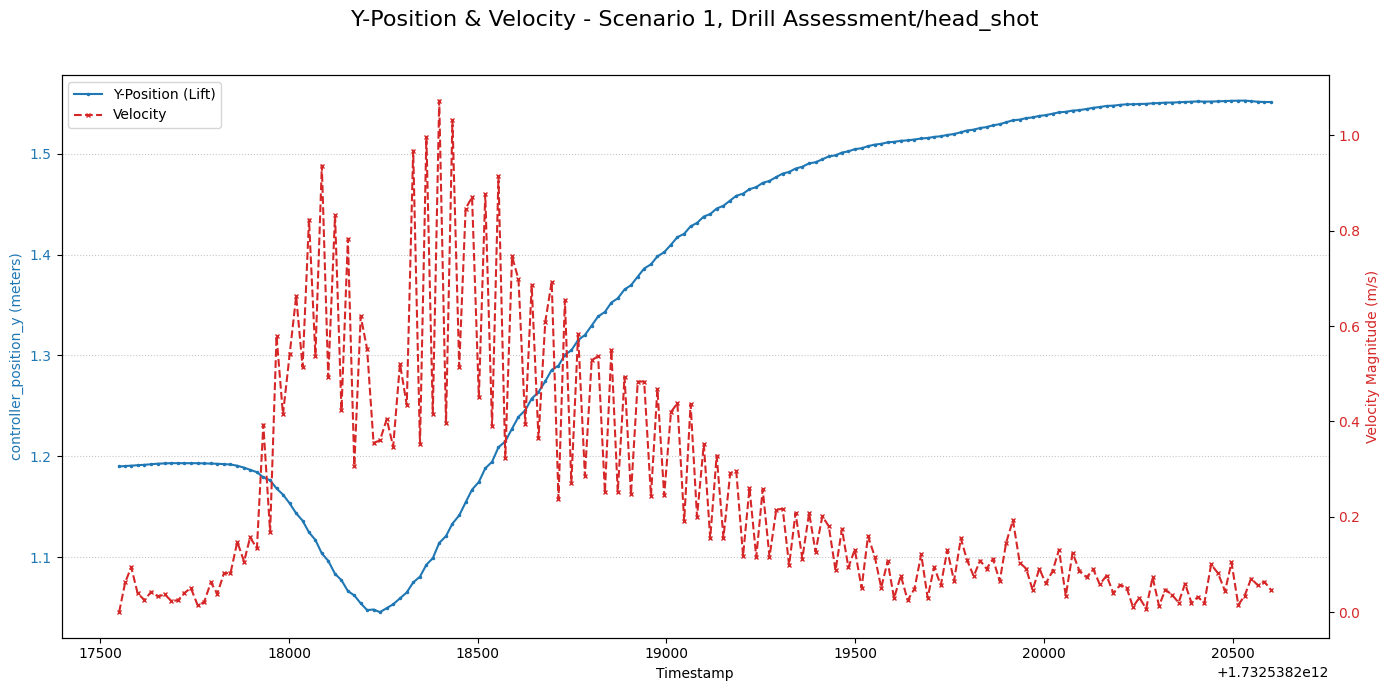

    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_1/combined_Y_Vel_drill_Assessment_double_tap.png


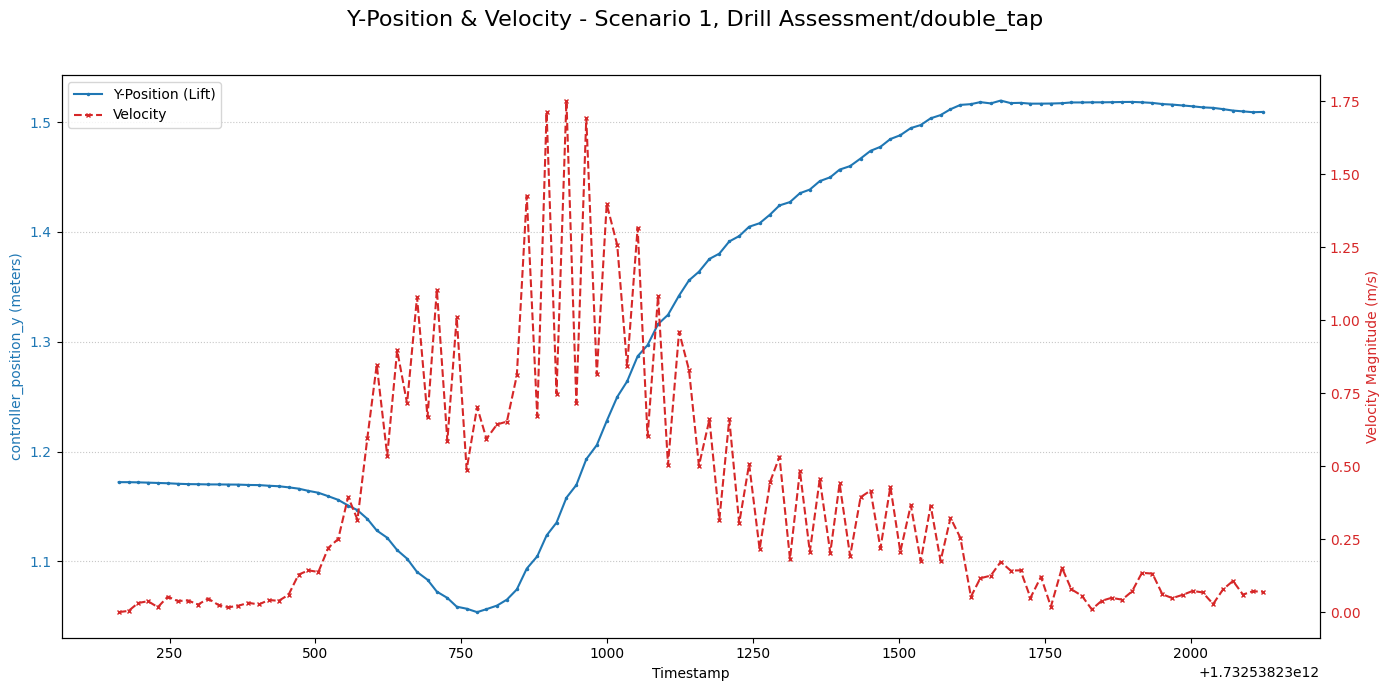

    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_1/combined_Y_Vel_drill_Assessment_failure.png


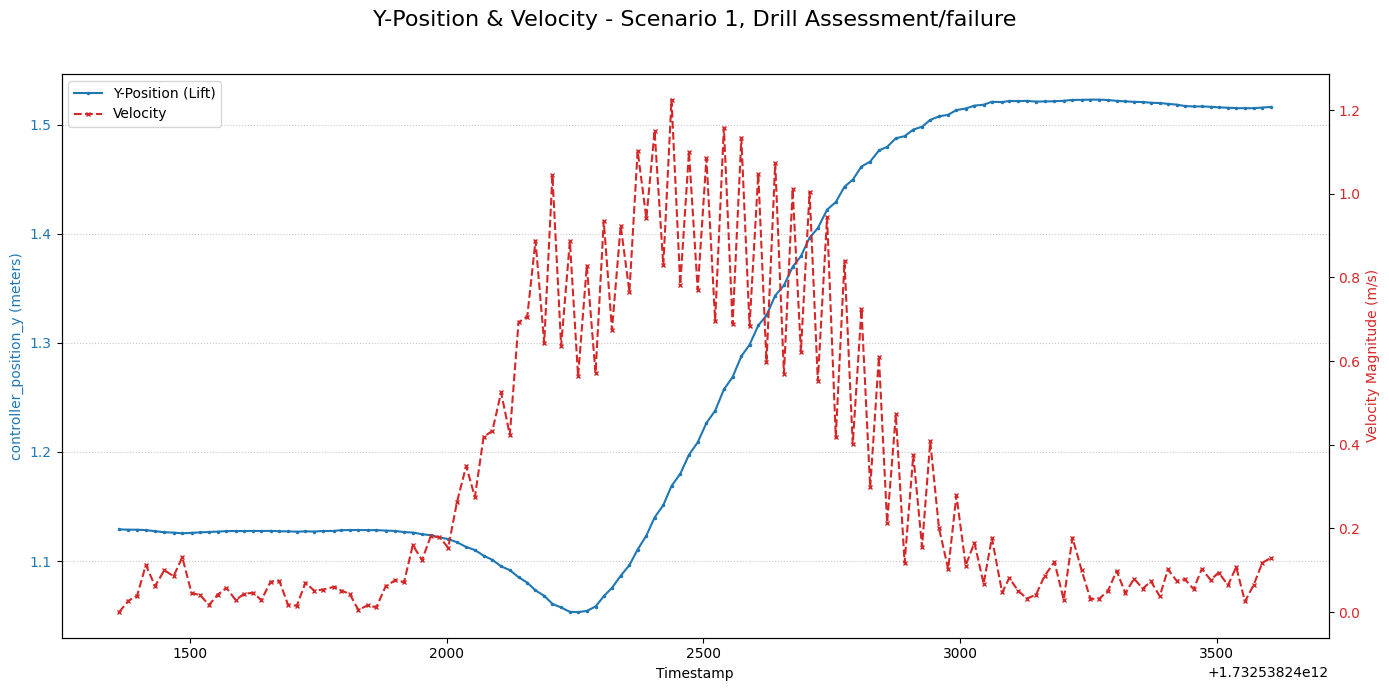

    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_1/combined_Y_Vel_drill_Assessment_reload.png


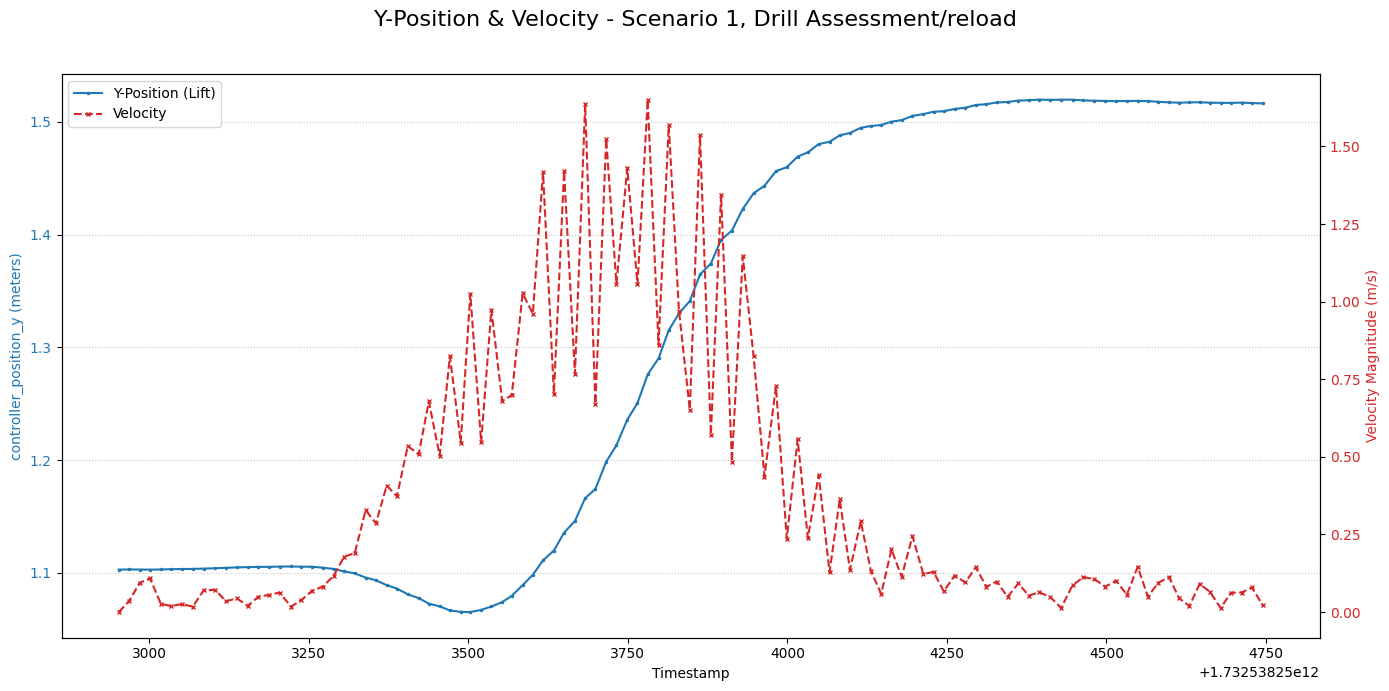

    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_1/combined_Y_Vel_drill_Assessment_forty_five.png


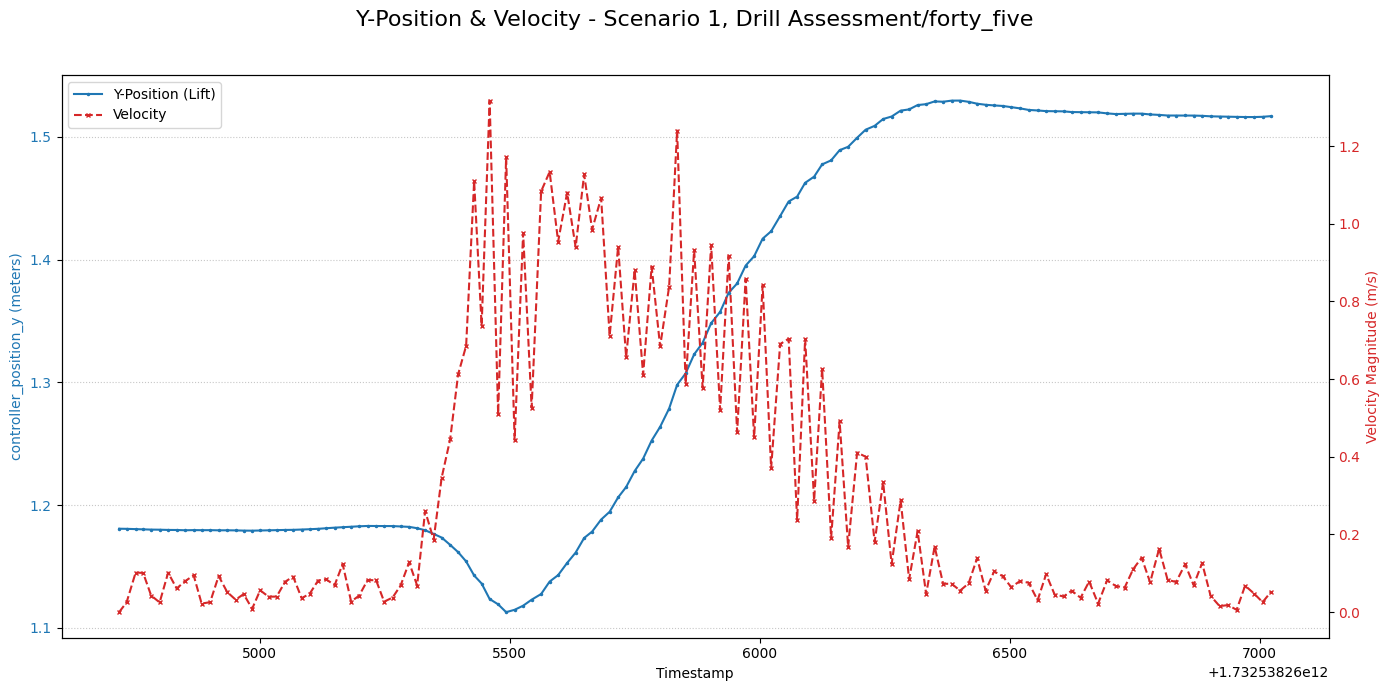

    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_1/combined_Y_Vel_drill_Assessment_el_presidente.png


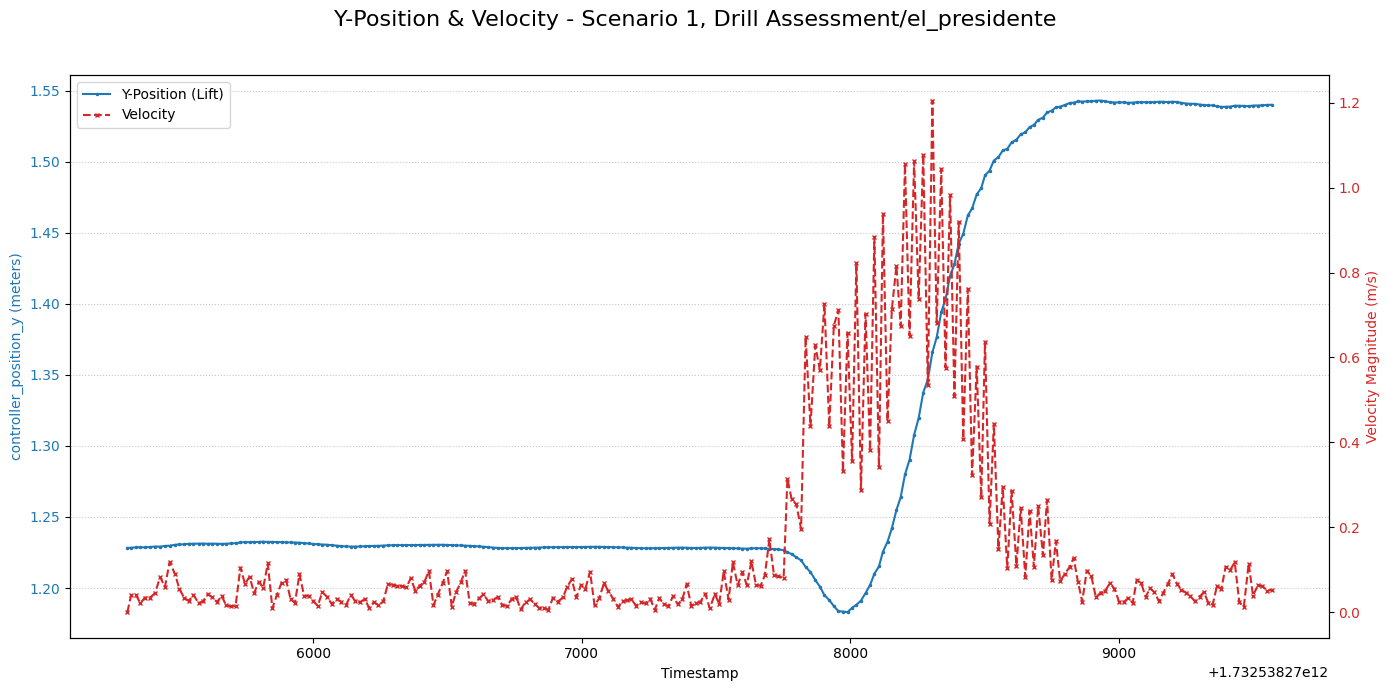

    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_1/combined_Y_Vel_drill_Assessment_lobby.png


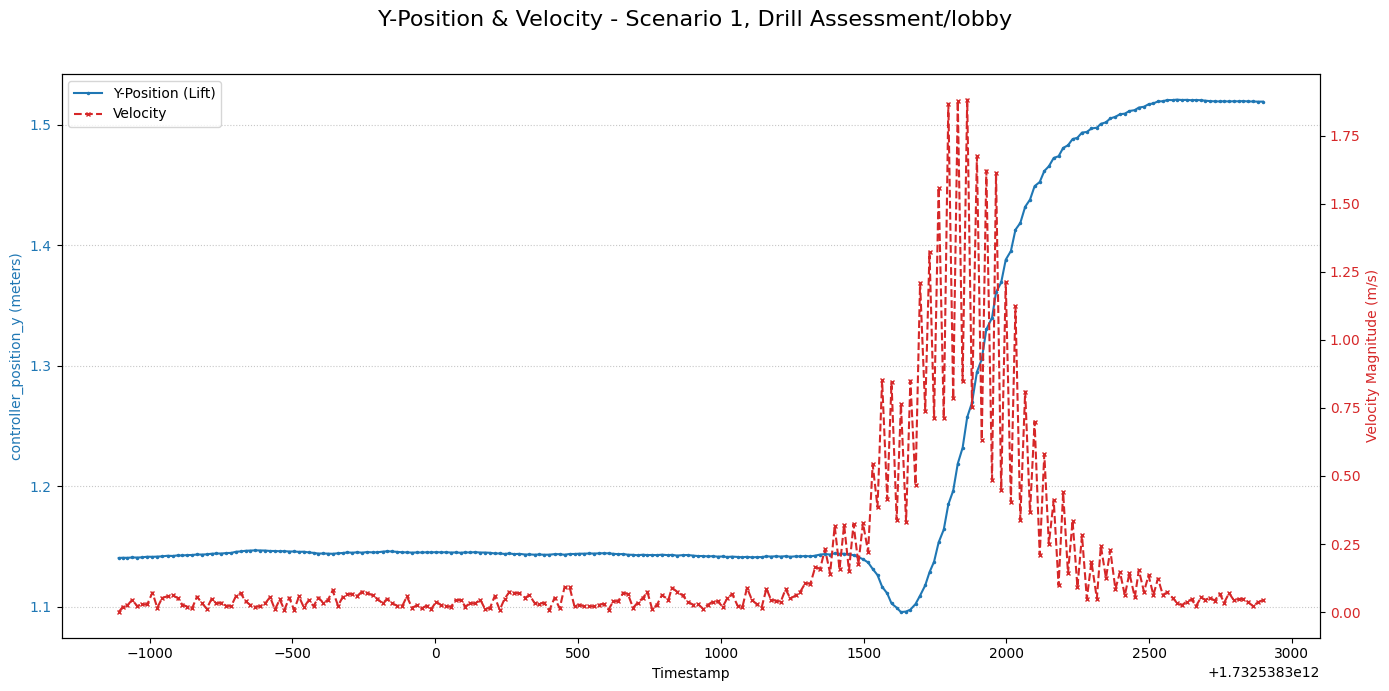

    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_1/combined_Y_Vel_drill_Assessment_jack_wilson.png


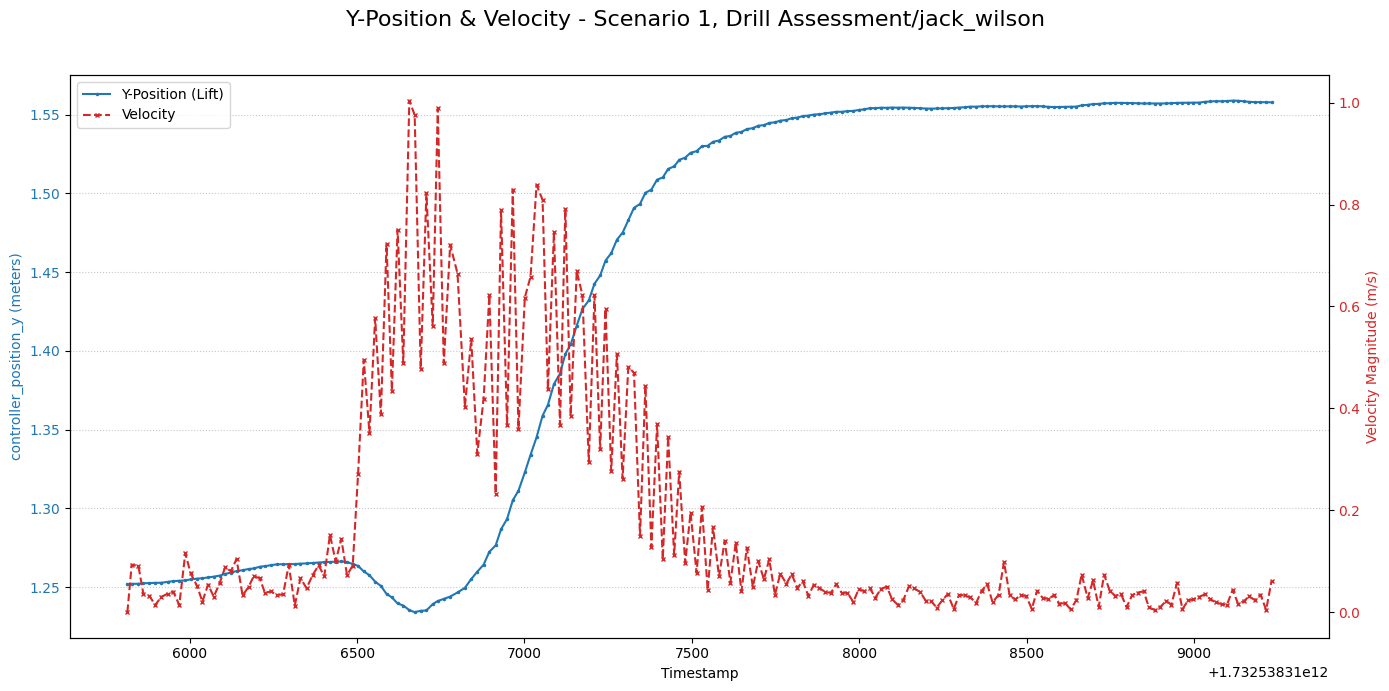

  Generated histogram of all velocities: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_1/histogram_velocities.png


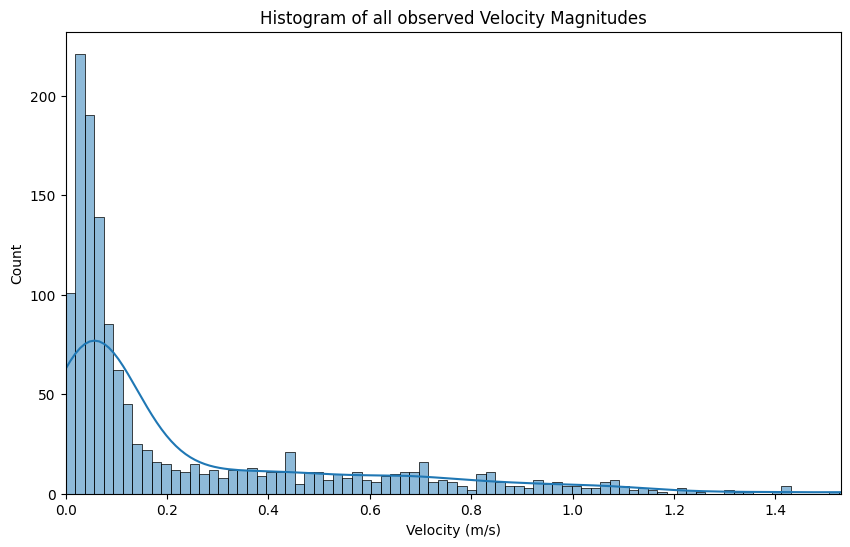

--- End of Threshold EDA for this scenario ---
Review generated plots and adjust ALL_THRESHOLDS if needed before full analysis.

--- Loading and Preparing Scenario: 2 ---
Event File: /content/drive/MyDrive/Weapon_presentation/2024.11.25.15.11.54.scenario2.event.evt
Frame File: /content/drive/MyDrive/Weapon_presentation/2024.11.25.15.11.54.scenario2.frame.csv

--- Exploratory Data Analysis for Thresholds (Scenario: 2) ---
 output_dir : /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_2
    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_2/combined_Y_Vel_drill_Assessment_head_shot.png


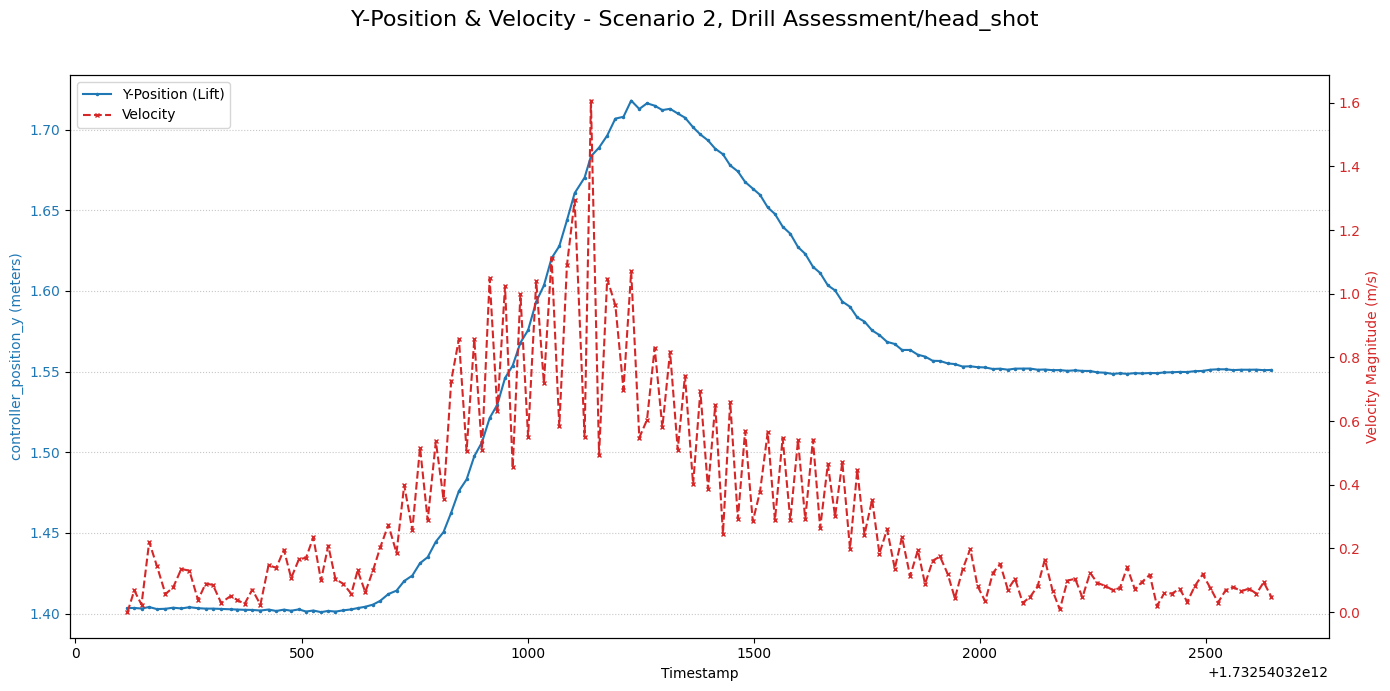

    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_2/combined_Y_Vel_drill_Assessment_double_tap.png


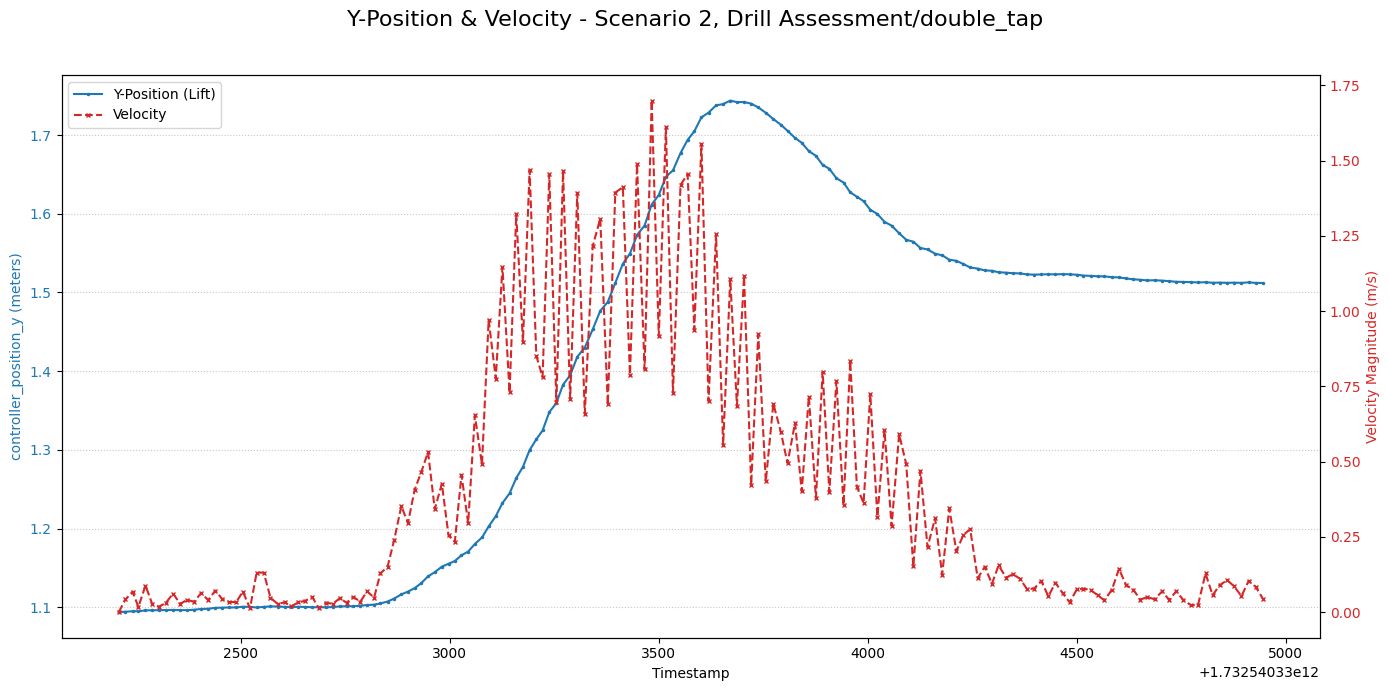

    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_2/combined_Y_Vel_drill_Assessment_failure.png


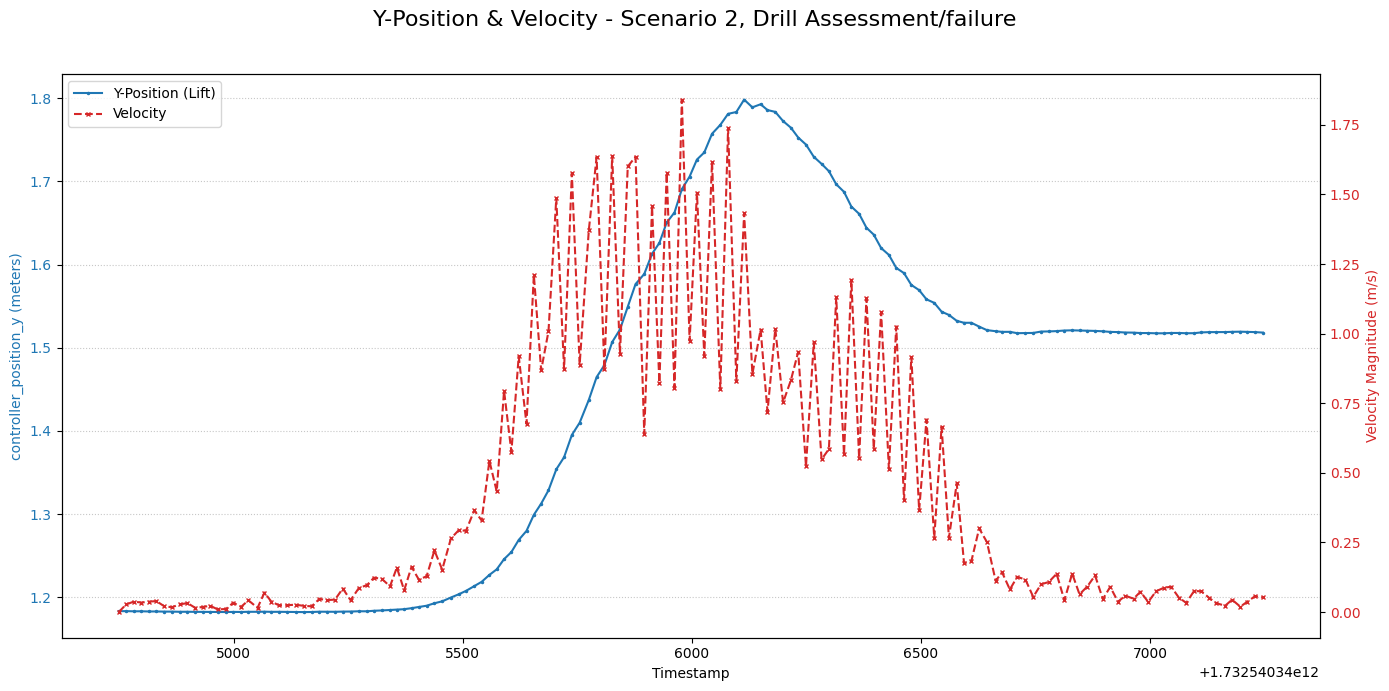

    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_2/combined_Y_Vel_drill_Assessment_reload.png


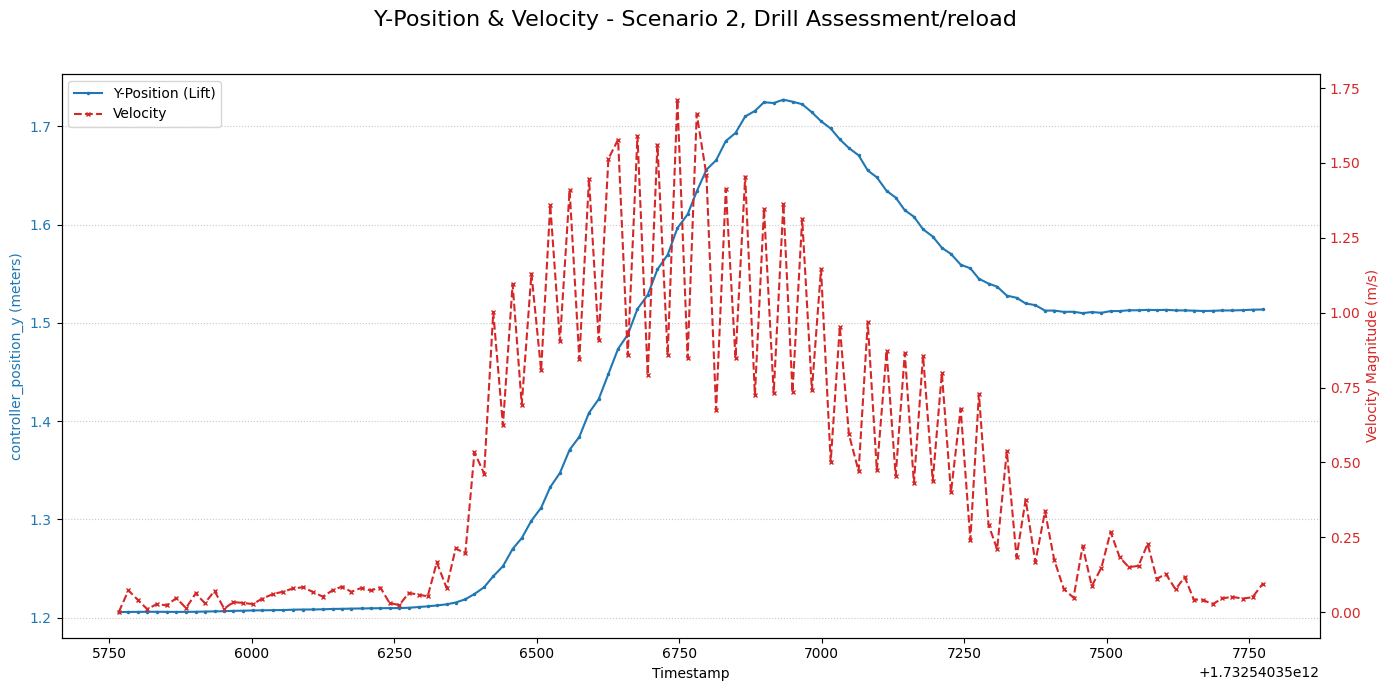

    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_2/combined_Y_Vel_drill_Assessment_forty_five.png


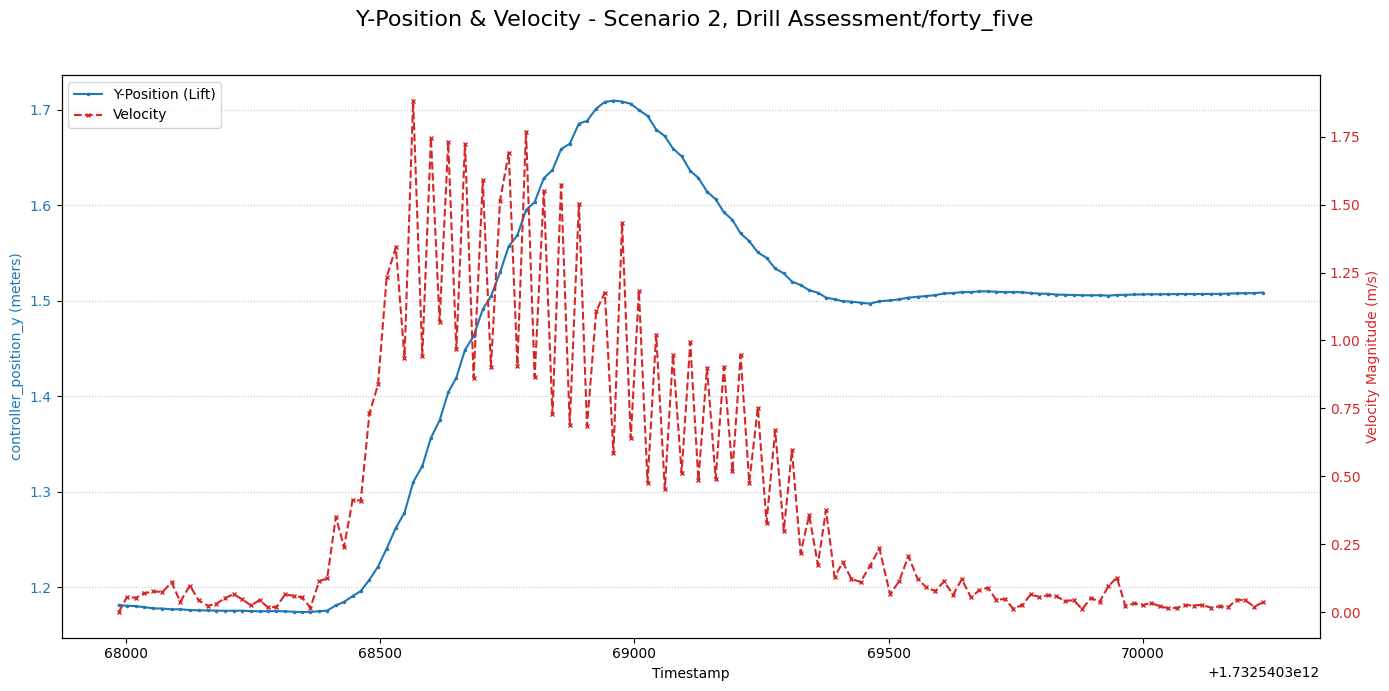

    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_2/combined_Y_Vel_drill_Assessment_el_presidente.png


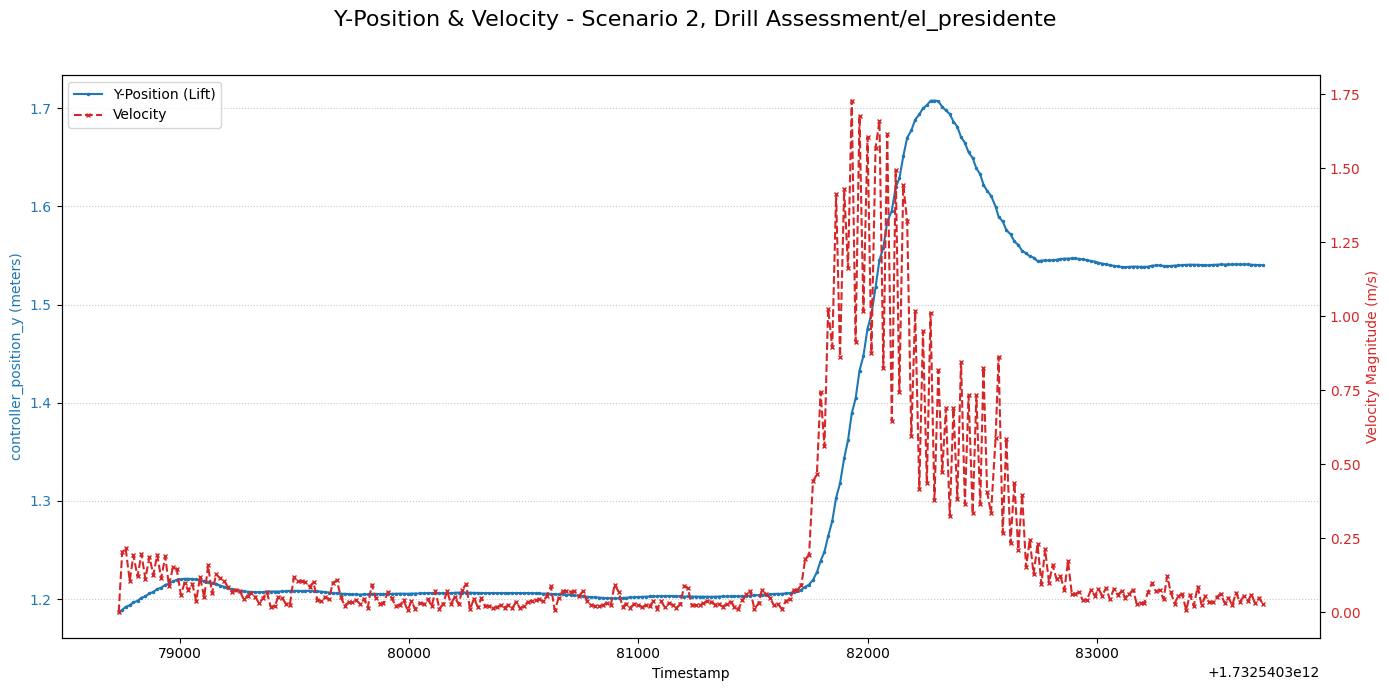

    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_2/combined_Y_Vel_drill_Assessment_lobby.png


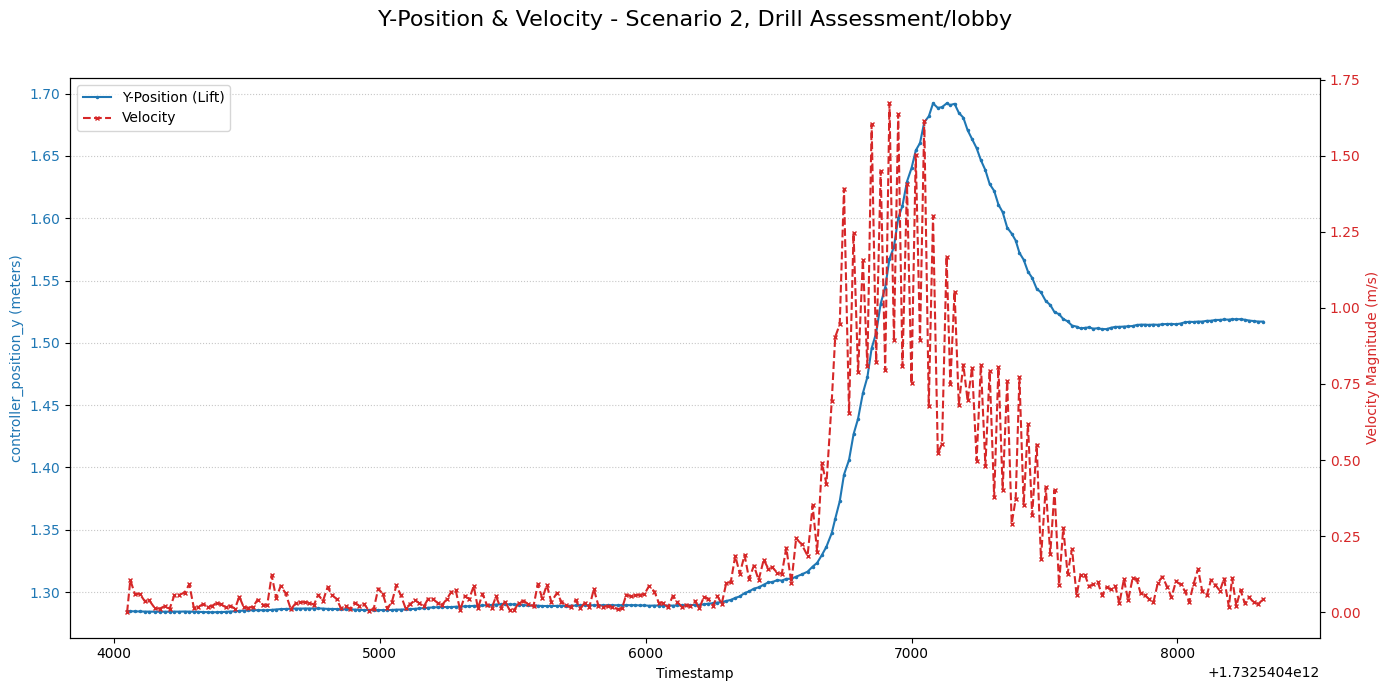

    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_2/combined_Y_Vel_drill_Assessment_jack_wilson.png


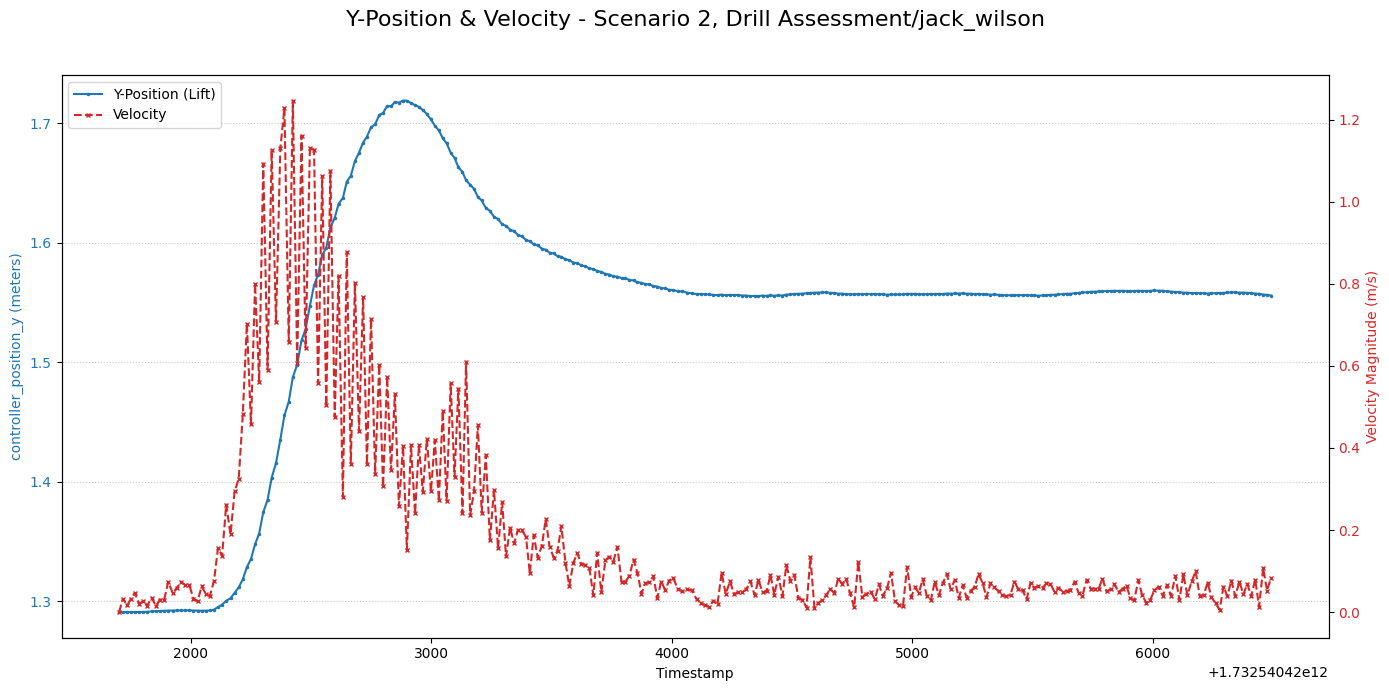

  Generated histogram of all velocities: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_2/histogram_velocities.png


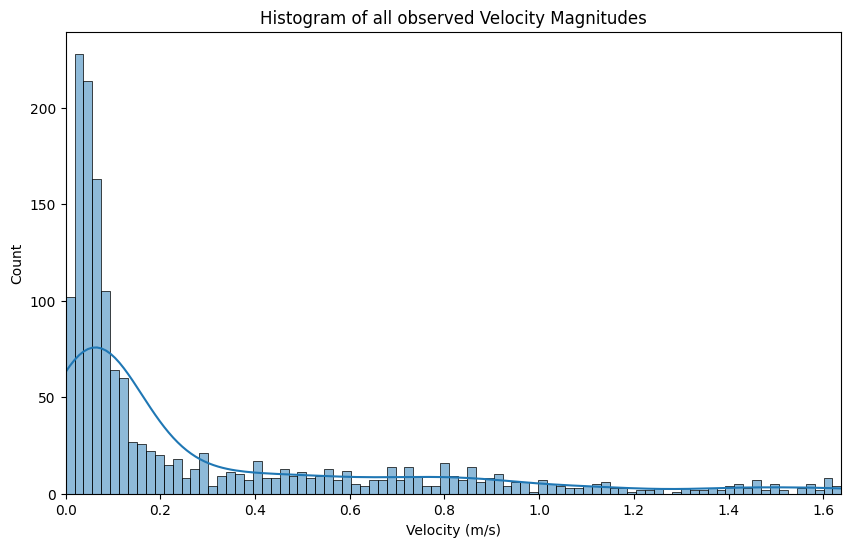

--- End of Threshold EDA for this scenario ---
Review generated plots and adjust ALL_THRESHOLDS if needed before full analysis.

--- Loading and Preparing Scenario: 3 ---
Event File: /content/drive/MyDrive/Weapon_presentation/2024.11.25.15.14.45.scenario3.event.evt
Frame File: /content/drive/MyDrive/Weapon_presentation/2024.11.25.15.14.45.scenario3.frame.csv

--- Exploratory Data Analysis for Thresholds (Scenario: 3) ---
 output_dir : /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_3
    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_3/combined_Y_Vel_drill_Assessment_head_shot.png


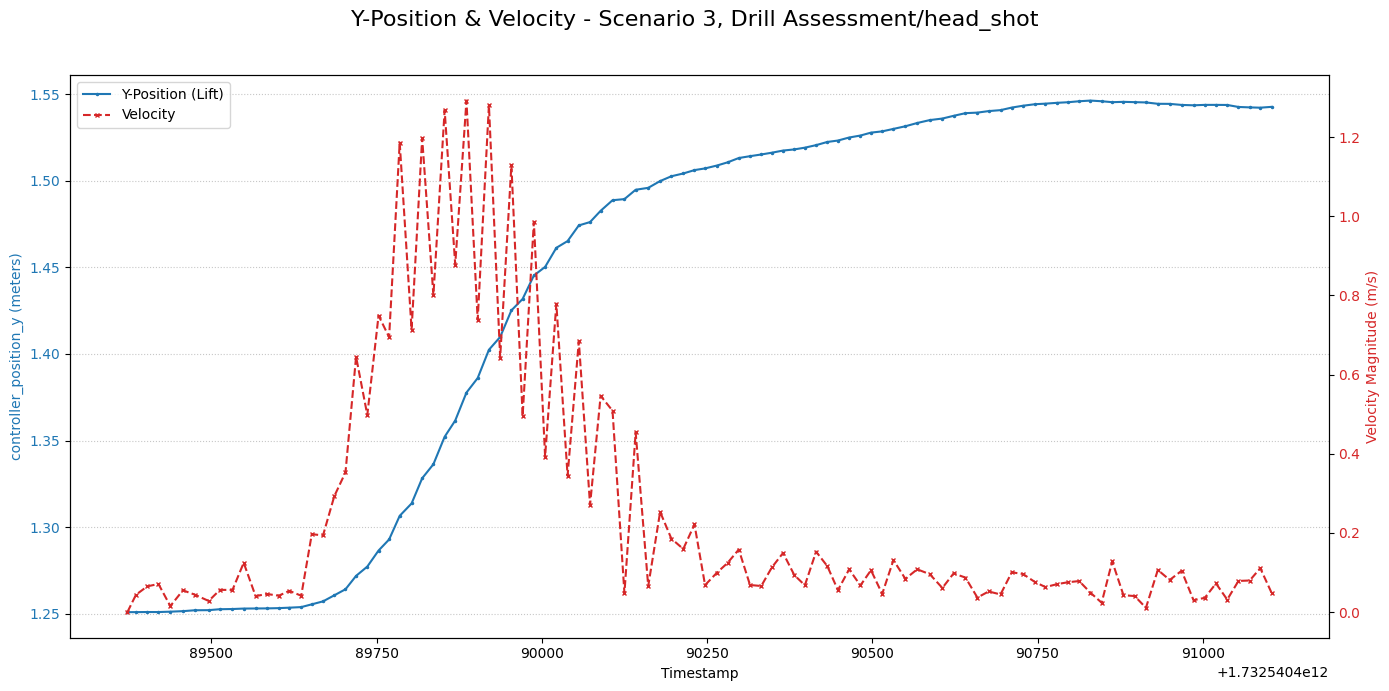

    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_3/combined_Y_Vel_drill_Assessment_double_tap.png


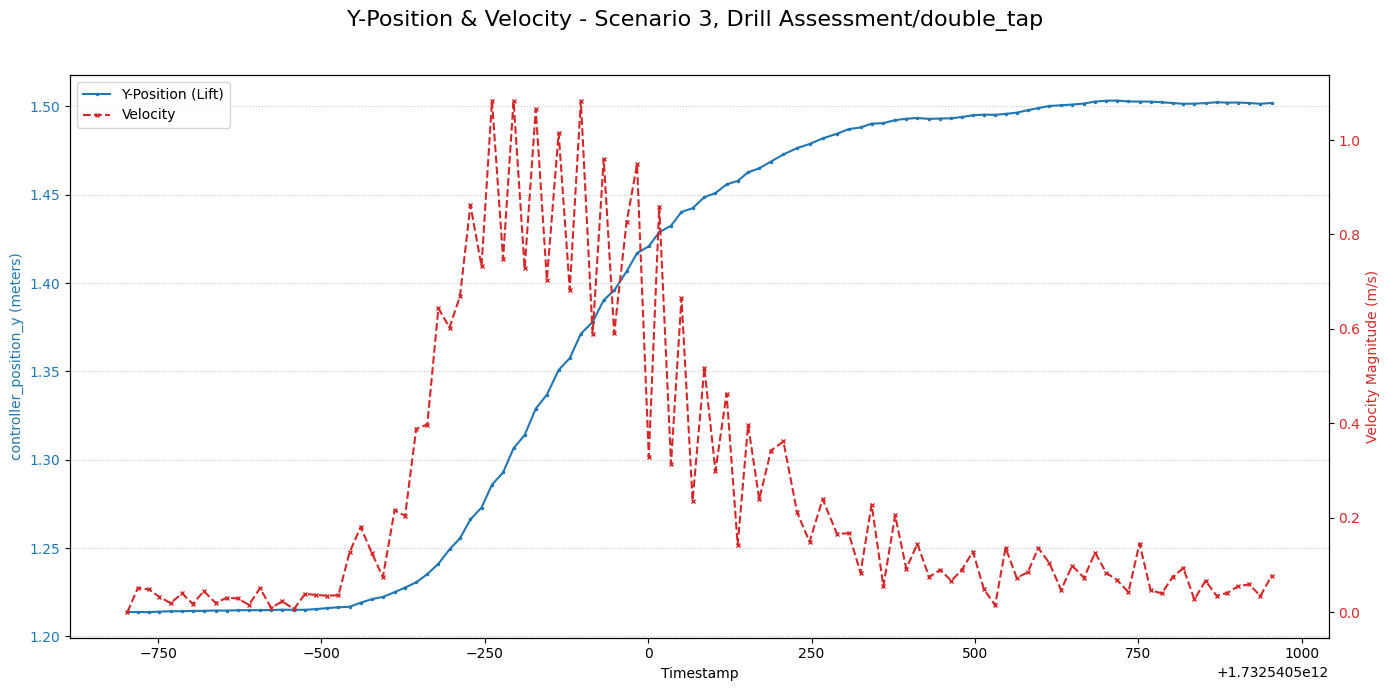

    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_3/combined_Y_Vel_drill_Assessment_failure.png


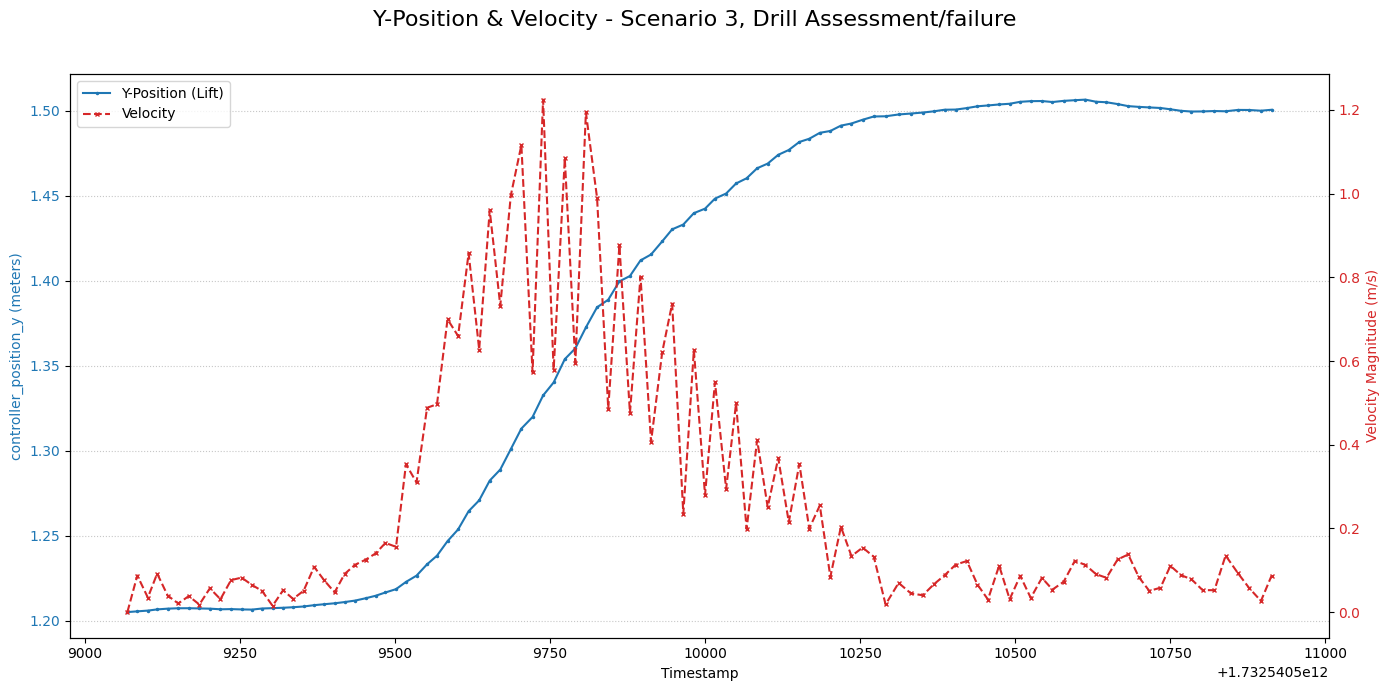

    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_3/combined_Y_Vel_drill_Assessment_reload.png


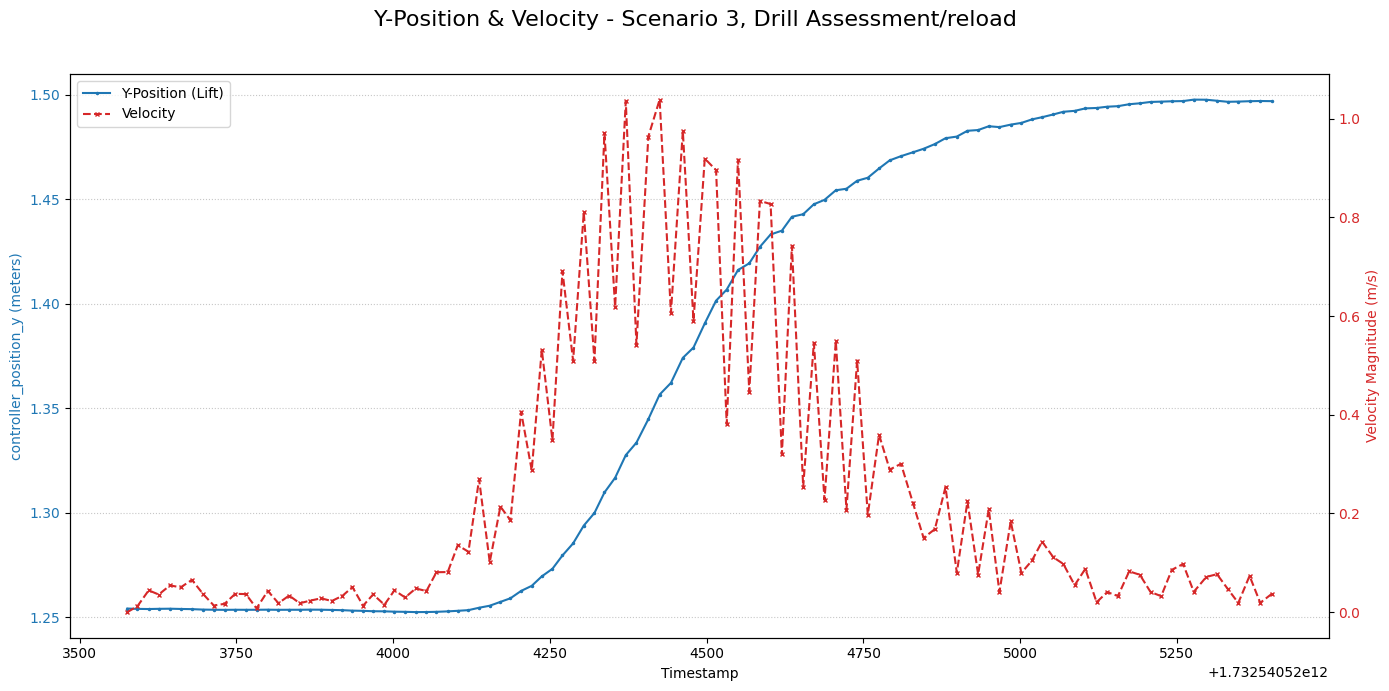

    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_3/combined_Y_Vel_drill_Assessment_forty_five.png


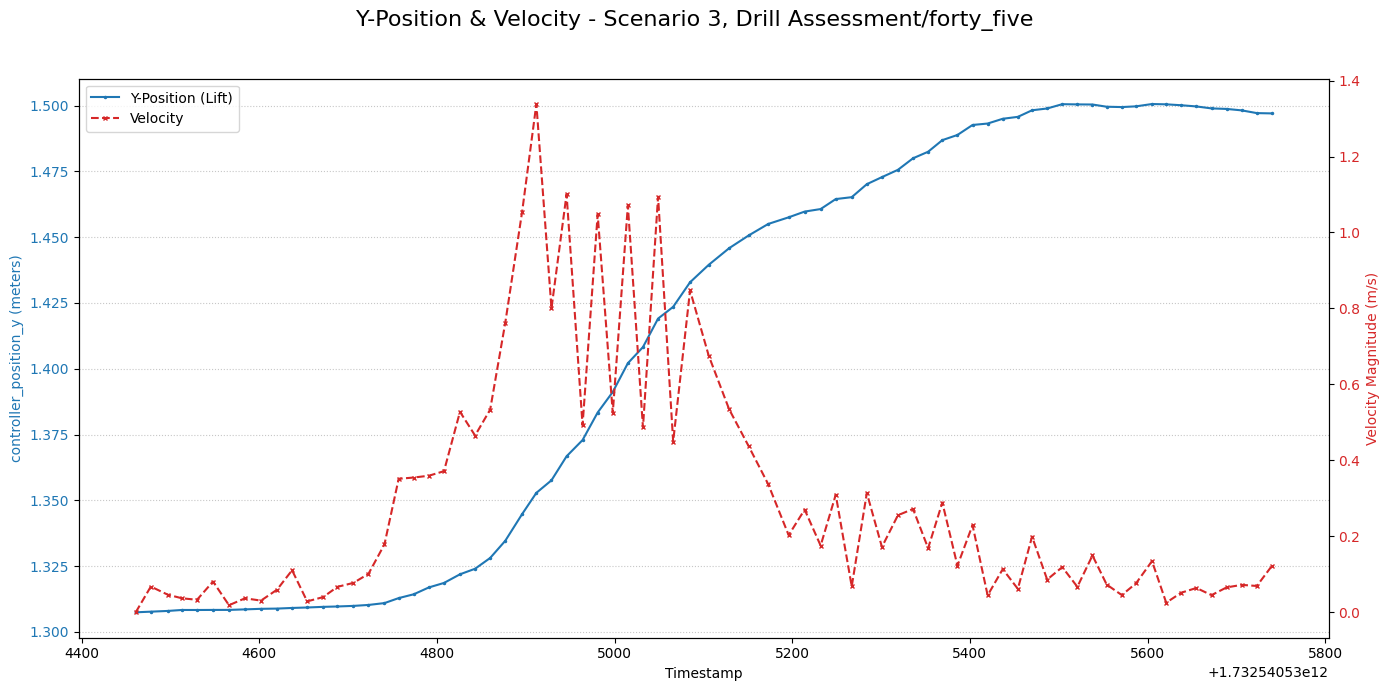

    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_3/combined_Y_Vel_drill_Assessment_el_presidente.png


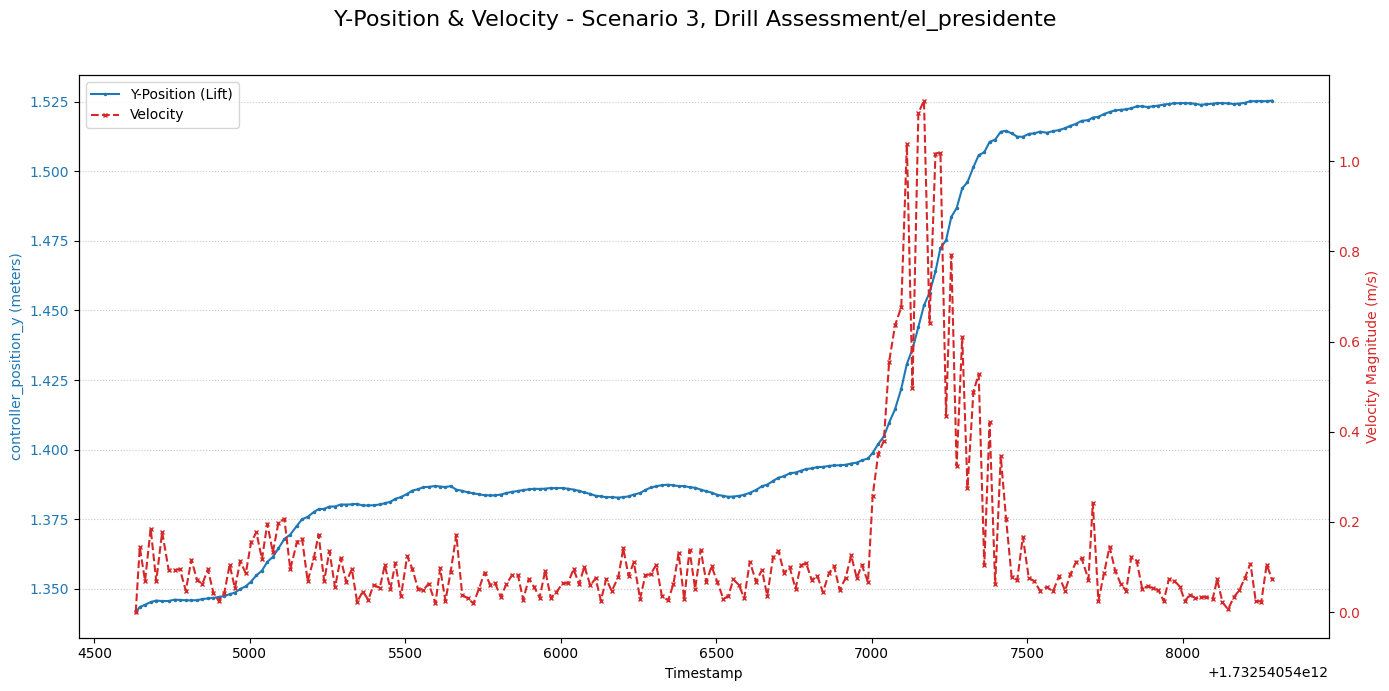

    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_3/combined_Y_Vel_drill_Assessment_lobby.png


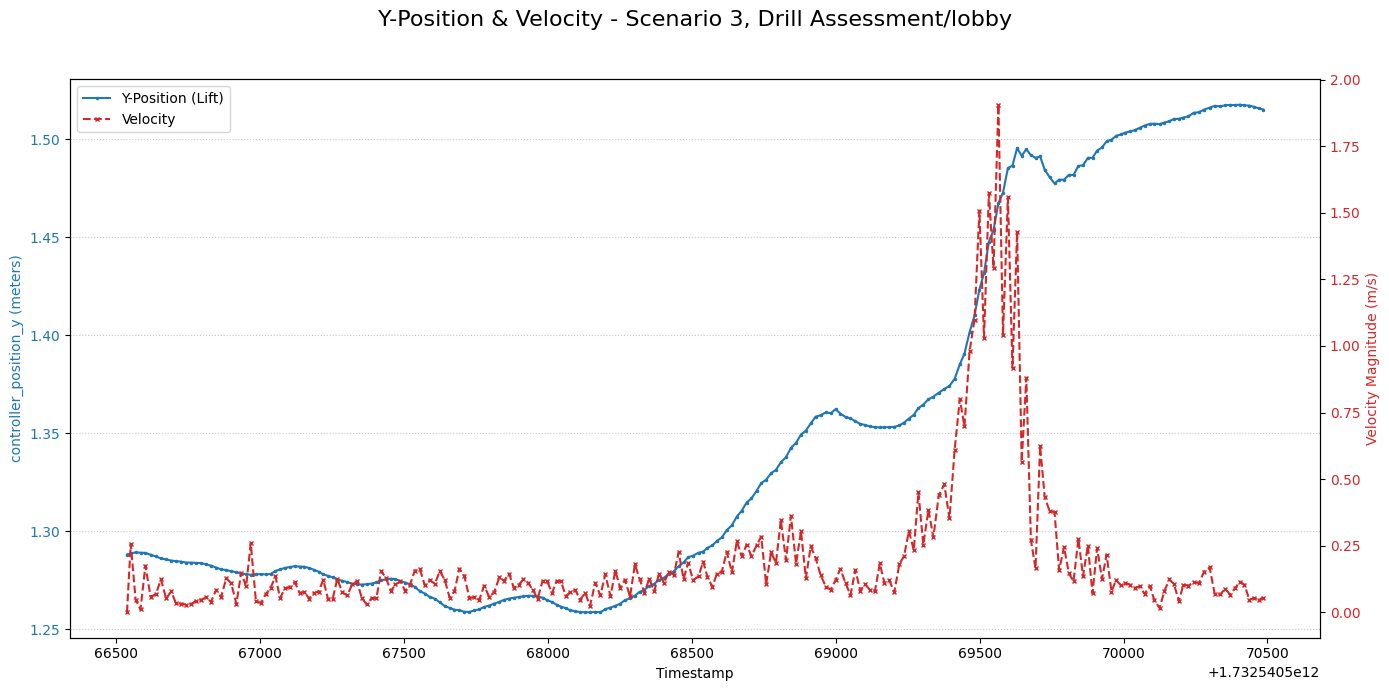

    Saved combined plot: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_3/combined_Y_Vel_drill_Assessment_jack_wilson.png


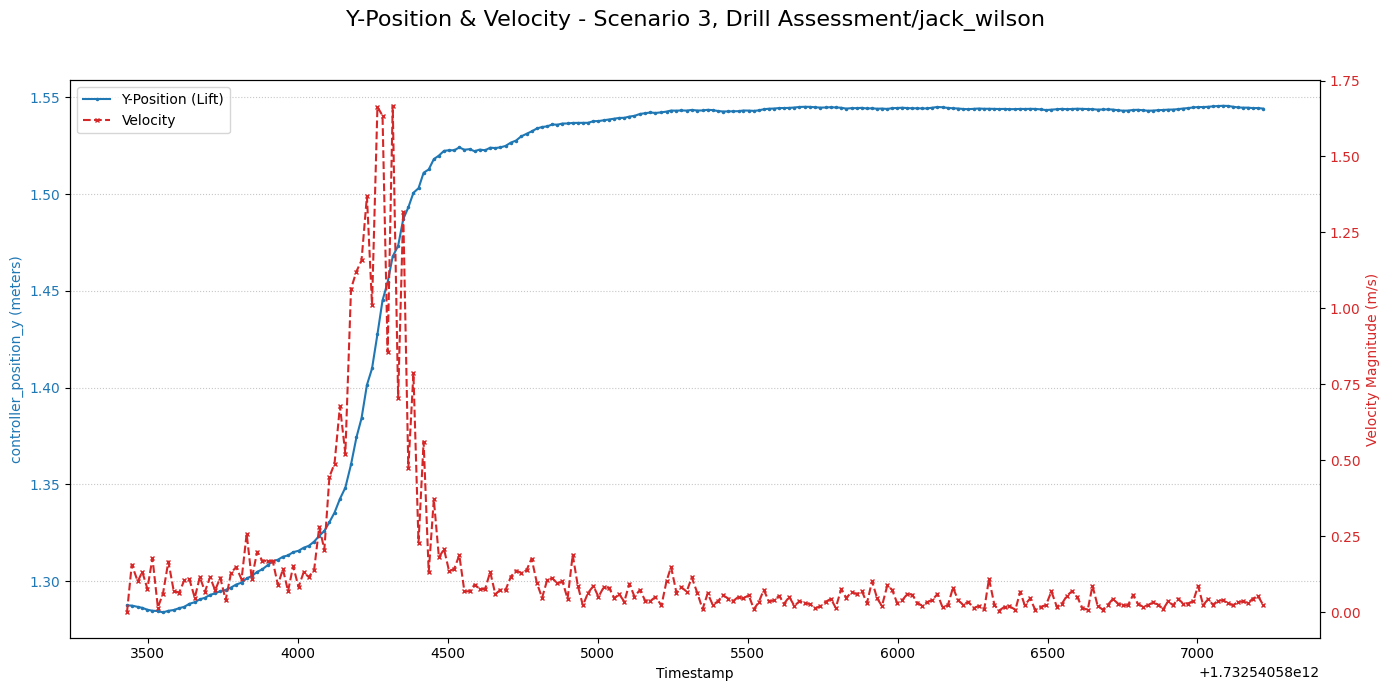

  Generated histogram of all velocities: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots_for_threshold_eval/scenario_3/histogram_velocities.png


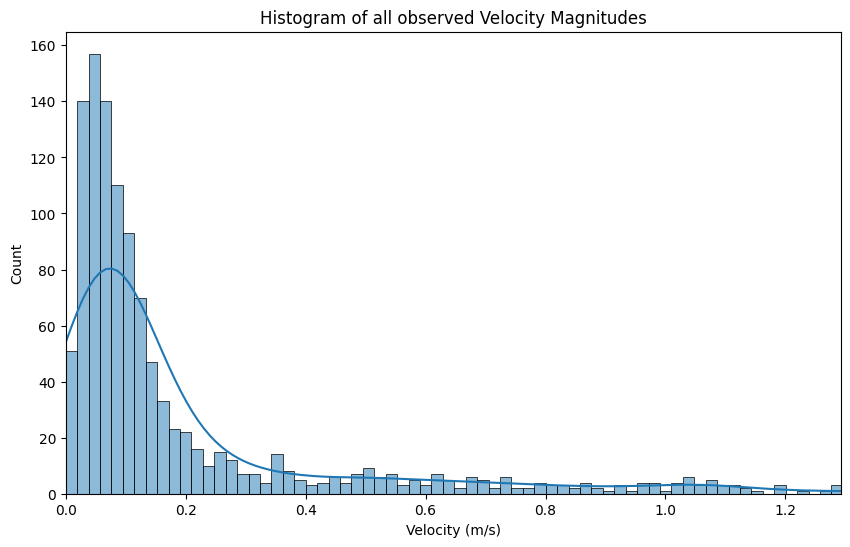

--- End of Threshold EDA for this scenario ---
Review generated plots and adjust ALL_THRESHOLDS if needed before full analysis.


In [61]:

# --- Data Loading and Optional EDA for Thresholds ---
loaded_scenario_data = []
for config in scenario_configurations:
        events, frame_df, drills = load_and_prepare_scenario_data(
            config["id"], config["event_file"], config["frame_file"]
        )
        if events is not None: # Check if loading was successful
            loaded_scenario_data.append({
                "id": config["id"],
                "events": events,
                "frame_df": frame_df,
                "drills_to_analyze": drills
            })

            # Call EDA for threshold exploration for this specific scenario's data
            explore_data_for_thresholds(config["id"], frame_df, drills, WEAPON_POS_COLS,relative_path + PLOT_OUTPUT_DIR_BASE )

In [68]:
 # --- Main Analysis Run (using potentially updated ALL_THRESHOLDS) ---

CURVE_CLASSIFICATION_LOG_FILE = relative_path + "curve_classification_details.log"
PLOT_OUTPUT_DIR_BASE = relative_path+ "all_scenario_plots"
with open(CURVE_CLASSIFICATION_LOG_FILE, 'w') as f:
  f.write("Curve Classification Log\n")
  f.write("==========================\n\n")

  all_overall_metrics = []
  for scenario_data in loaded_scenario_data:
         scenario_metrics = analyze_scenario_drills(
             scenario_data["id"],
             scenario_data["frame_df"],
             scenario_data["drills_to_analyze"],
             WEAPON_POS_COLS,
             ALL_THRESHOLDS,
             PLOT_OUTPUT_DIR_BASE,
             CURVE_CLASSIFICATION_LOG_FILE
          )
         all_overall_metrics.extend(scenario_metrics)

    # --- Aggregate and Output Final Results & EDA on Results ---
if all_overall_metrics:
        final_results_df = pd.DataFrame(all_overall_metrics)
        print("\n\n--- All Scenarios - Weapon Presentation Analysis Results ---")
        if not final_results_df.empty:
            display_cols = ["scenario_id", "drill_uid", "speed_ms", "motion_length_cm", "curve_type_dev","curve_type_poly",
                            "T_presentation_start_calc", "T_presentation_end_calc",
                            "T_drill_start_event", "T_first_shot_event", "reaction_time","error"]
            existing_display_cols = [col for col in display_cols if col in final_results_df.columns]
            print(final_results_df[existing_display_cols].to_string())
            # perform_exploratory_analysis(final_results_df) #  existing EDA on final results
        else:
            print("No aggregated results to display.")

else:
        print("No analysis results generated across all scenarios.")


--- Analyzing Drills for Scenario: 1 ---

  Analyzing Drill: Assessment/head_shot (Start: 1732538217548, First Shot: 1732538220618) for Scenario 1
  Analysis Results: Speed=1048ms, Motion=31.47cm, Curve=other, Curve_fit_polynomial=line, PresStart=1732538218555, PresEnd=1732538219603, reaction time(ms_=1007
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_1/drill_Assessment_head_shot_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_1/user_drill_Assessment_head_shot_presentation.png

  Analyzing Drill: Assessment/double_tap (Start: 1732538230160, First Shot: 1732538232140) for Scenario 1
  Analysis Results: Speed=848ms, Motion=38.42cm, Curve=swing, Curve_fit_polynomial=line, PresStart=1732538230947, PresEnd=1732538231795, reaction time(ms_=787
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_1/drill_Assessment_double_tap_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_1/user_drill_Assessment_double_tap_presentation.png

  Analyzing Drill: Assessment/failure (Start: 1732538241360, First Shot: 1732538243621) for Scenario 1
  Analysis Results: Speed=677ms, Motion=40.02cm, Curve=swing, Curve_fit_polynomial=line, PresStart=1732538242405, PresEnd=1732538243082, reaction time(ms_=1045
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_1/drill_Assessment_failure_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_1/user_drill_Assessment_failure_presentation.png

  Analyzing Drill: Assessment/reload (Start: 1732538252950, First Shot: 1732538254761) for Scenario 1
  Analysis Results: Speed=695ms, Motion=44.42cm, Curve=other, Curve_fit_polynomial=swing, PresStart=1732538253617, PresEnd=1732538254312, reaction time(ms_=667
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_1/drill_Assessment_reload_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_1/user_drill_Assessment_reload_presentation.png

  Analyzing Drill: Assessment/forty_five (Start: 1732538264717, First Shot: 1732538267040) for Scenario 1
  Analysis Results: Speed=667ms, Motion=35.08cm, Curve=other, Curve_fit_polynomial=line, PresStart=1732538265700, PresEnd=1732538266367, reaction time(ms_=983
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_1/drill_Assessment_forty_five_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_1/user_drill_Assessment_forty_five_presentation.png

  Analyzing Drill: Assessment/el_presidente (Start: 1732538275303, First Shot: 1732538279584) for Scenario 1
  Analysis Results: Speed=693ms, Motion=31.60cm, Curve=other, Curve_fit_polynomial=swing, PresStart=1732538278155, PresEnd=1732538278848, reaction time(ms_=2852
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_1/drill_Assessment_el_presidente_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_1/user_drill_Assessment_el_presidente_presentation.png

  Analyzing Drill: Assessment/lobby (Start: 1732538298888, First Shot: 1732538302912) for Scenario 1
  Analysis Results: Speed=785ms, Motion=40.92cm, Curve=other, Curve_fit_polynomial=line, PresStart=1732538301763, PresEnd=1732538302548, reaction time(ms_=2875
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_1/drill_Assessment_lobby_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_1/user_drill_Assessment_lobby_presentation.png

  Analyzing Drill: Assessment/jack_wilson (Start: 1732538315809, First Shot: 1732538319247) for Scenario 1
  Analysis Results: Speed=853ms, Motion=29.01cm, Curve=other, Curve_fit_polynomial=line, PresStart=1732538316895, PresEnd=1732538317748, reaction time(ms_=1086
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_1/drill_Assessment_jack_wilson_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_1/user_drill_Assessment_jack_wilson_presentation.png

--- Analyzing Drills for Scenario: 2 ---

  Analyzing Drill: Assessment/head_shot (Start: 1732540320112, First Shot: 1732540322661) for Scenario 2
  Analysis Results: Speed=1350ms, Motion=67.30cm, Curve=push, Curve_fit_polynomial=push, PresStart=1732540320745, PresEnd=1732540322095, reaction time(ms_=633
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_2/drill_Assessment_head_shot_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_2/user_drill_Assessment_head_shot_presentation.png

  Analyzing Drill: Assessment/double_tap (Start: 1732540332205, First Shot: 1732540334961) for Scenario 2
  Analysis Results: Speed=1548ms, Motion=103.33cm, Curve=push, Curve_fit_polynomial=other, PresStart=1732540332884, PresEnd=1732540334432, reaction time(ms_=679
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_2/drill_Assessment_double_tap_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_2/user_drill_Assessment_double_tap_presentation.png

  Analyzing Drill: Assessment/failure (Start: 1732540344747, First Shot: 1732540347262) for Scenario 2
  Analysis Results: Speed=1406ms, Motion=104.57cm, Curve=push, Curve_fit_polynomial=other, PresStart=1732540345491, PresEnd=1732540346897, reaction time(ms_=744
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_2/drill_Assessment_failure_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_2/user_drill_Assessment_failure_presentation.png

  Analyzing Drill: Assessment/reload (Start: 1732540355765, First Shot: 1732540357790) for Scenario 2
  Analysis Results: Speed=1262ms, Motion=91.28cm, Curve=push, Curve_fit_polynomial=other, PresStart=1732540356391, PresEnd=1732540357653, reaction time(ms_=626
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_2/drill_Assessment_reload_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_2/user_drill_Assessment_reload_presentation.png

  Analyzing Drill: Assessment/forty_five (Start: 1732540367984, First Shot: 1732540370252) for Scenario 2
  Analysis Results: Speed=1200ms, Motion=90.36cm, Curve=push, Curve_fit_polynomial=other, PresStart=1732540368462, PresEnd=1732540369662, reaction time(ms_=478
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_2/drill_Assessment_forty_five_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_2/user_drill_Assessment_forty_five_presentation.png

  Analyzing Drill: Assessment/el_presidente (Start: 1732540378728, First Shot: 1732540383741) for Scenario 2
  Analysis Results: Speed=1164ms, Motion=79.07cm, Curve=push, Curve_fit_polynomial=push, PresStart=1732540381728, PresEnd=1732540382892, reaction time(ms_=3000
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_2/drill_Assessment_el_presidente_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_2/user_drill_Assessment_el_presidente_presentation.png

  Analyzing Drill: Assessment/lobby (Start: 1732540404044, First Shot: 1732540408340) for Scenario 2
  Analysis Results: Speed=1102ms, Motion=75.75cm, Curve=push, Curve_fit_polynomial=other, PresStart=1732540406566, PresEnd=1732540407668, reaction time(ms_=2522
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_2/drill_Assessment_lobby_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_2/user_drill_Assessment_lobby_presentation.png

  Analyzing Drill: Assessment/jack_wilson (Start: 1732540421700, First Shot: 1732540426506) for Scenario 2
  Analysis Results: Speed=1591ms, Motion=68.59cm, Curve=push, Curve_fit_polynomial=push, PresStart=1732540422200, PresEnd=1732540423791, reaction time(ms_=500
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_2/drill_Assessment_jack_wilson_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_2/user_drill_Assessment_jack_wilson_presentation.png

--- Analyzing Drills for Scenario: 3 ---

  Analyzing Drill: Assessment/head_shot (Start: 1732540489368, First Shot: 1732540491120) for Scenario 3
  Analysis Results: Speed=868ms, Motion=36.36cm, Curve=other, Curve_fit_polynomial=line, PresStart=1732540489719, PresEnd=1732540490587, reaction time(ms_=351
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_3/drill_Assessment_head_shot_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_3/user_drill_Assessment_head_shot_presentation.png

  Analyzing Drill: Assessment/double_tap (Start: 1732540499201, First Shot: 1732540500970) for Scenario 3
  Analysis Results: Speed=768ms, Motion=38.58cm, Curve=other, Curve_fit_polynomial=line, PresStart=1732540499662, PresEnd=1732540500430, reaction time(ms_=461
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_3/drill_Assessment_double_tap_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_3/user_drill_Assessment_double_tap_presentation.png

  Analyzing Drill: Assessment/failure (Start: 1732540509067, First Shot: 1732540510931) for Scenario 3
  Analysis Results: Speed=756ms, Motion=40.69cm, Curve=swing, Curve_fit_polynomial=line, PresStart=1732540509535, PresEnd=1732540510291, reaction time(ms_=468
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_3/drill_Assessment_failure_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_3/user_drill_Assessment_failure_presentation.png

  Analyzing Drill: Assessment/reload (Start: 1732540523574, First Shot: 1732540525417) for Scenario 3
  Analysis Results: Speed=815ms, Motion=37.81cm, Curve=other, Curve_fit_polynomial=line, PresStart=1732540524254, PresEnd=1732540525069, reaction time(ms_=680
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_3/drill_Assessment_reload_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_3/user_drill_Assessment_reload_presentation.png

  Analyzing Drill: Assessment/forty_five (Start: 1732540534459, First Shot: 1732540535755) for Scenario 3
  Analysis Results: Speed=694ms, Motion=30.01cm, Curve=other, Curve_fit_polynomial=line, PresStart=1732540534860, PresEnd=1732540535554, reaction time(ms_=401
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_3/drill_Assessment_forty_five_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_3/user_drill_Assessment_forty_five_presentation.png

  Analyzing Drill: Assessment/el_presidente (Start: 1732540544628, First Shot: 1732540548304) for Scenario 3
  Analysis Results: Speed=502ms, Motion=25.23cm, Curve=other, Curve_fit_polynomial=line, PresStart=1732540547003, PresEnd=1732540547505, reaction time(ms_=2375
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_3/drill_Assessment_el_presidente_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_3/user_drill_Assessment_el_presidente_presentation.png

  Analyzing Drill: Assessment/lobby (Start: 1732540566533, First Shot: 1732540570500) for Scenario 3
  Analysis Results: Speed=1349ms, Motion=52.66cm, Curve=push, Curve_fit_polynomial=other, PresStart=1732540568690, PresEnd=1732540570039, reaction time(ms_=2157
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_3/drill_Assessment_lobby_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_3/user_drill_Assessment_lobby_presentation.png

  Analyzing Drill: Assessment/jack_wilson (Start: 1732540583429, First Shot: 1732540587235) for Scenario 3
  Analysis Results: Speed=484ms, Motion=33.79cm, Curve=other, Curve_fit_polynomial=line, PresStart=1732540584072, PresEnd=1732540584556, reaction time(ms_=643
  Plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_3/drill_Assessment_jack_wilson_presentation.png


<ipython-input-53-41d621f8948b>:105: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(P2-P1, P0-P1)) / np.linalg.norm(P2-P1)


  User plot saved: /content/drive/MyDrive/Weapon_presentation/all_scenario_plots/scenario_3/user_drill_Assessment_jack_wilson_presentation.png


--- All Scenarios - Weapon Presentation Analysis Results ---
   scenario_id                 drill_uid  speed_ms  motion_length_cm curve_type_dev curve_type_poly  T_presentation_start_calc  T_presentation_end_calc  T_drill_start_event  T_first_shot_event  reaction_time error
0            1      Assessment/head_shot      1048         31.467912          other            line              1732538218555            1732538219603        1732538217548       1732538220618           1007  None
1            1     Assessment/double_tap       848         38.417856          swing            line              1732538230947            1732538231795        1732538230160       1732538232140            787  None
2            1        Assessment/failure       677         40.017723          swing            line              1732538242405            1732538243082 



--- Exploratory Data Analysis ---


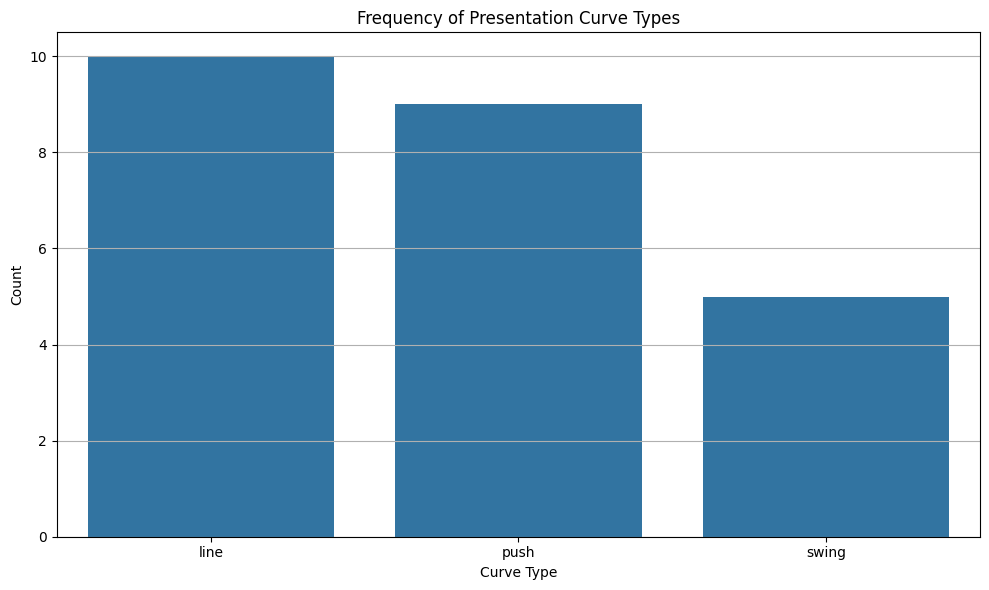

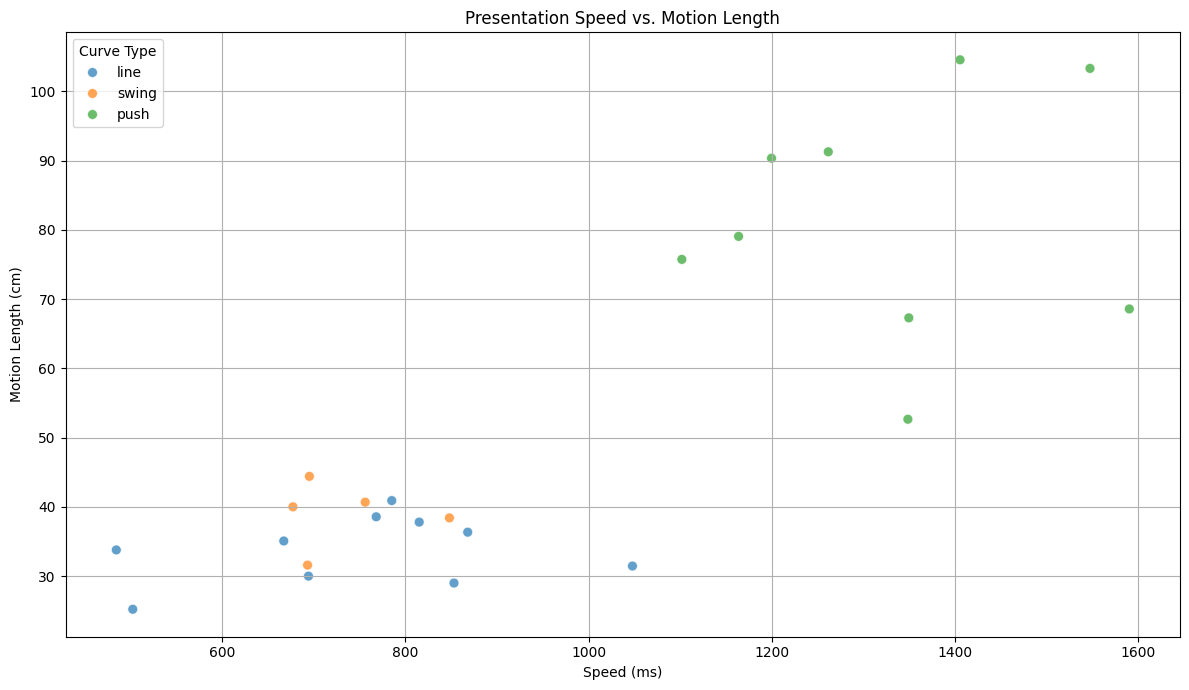

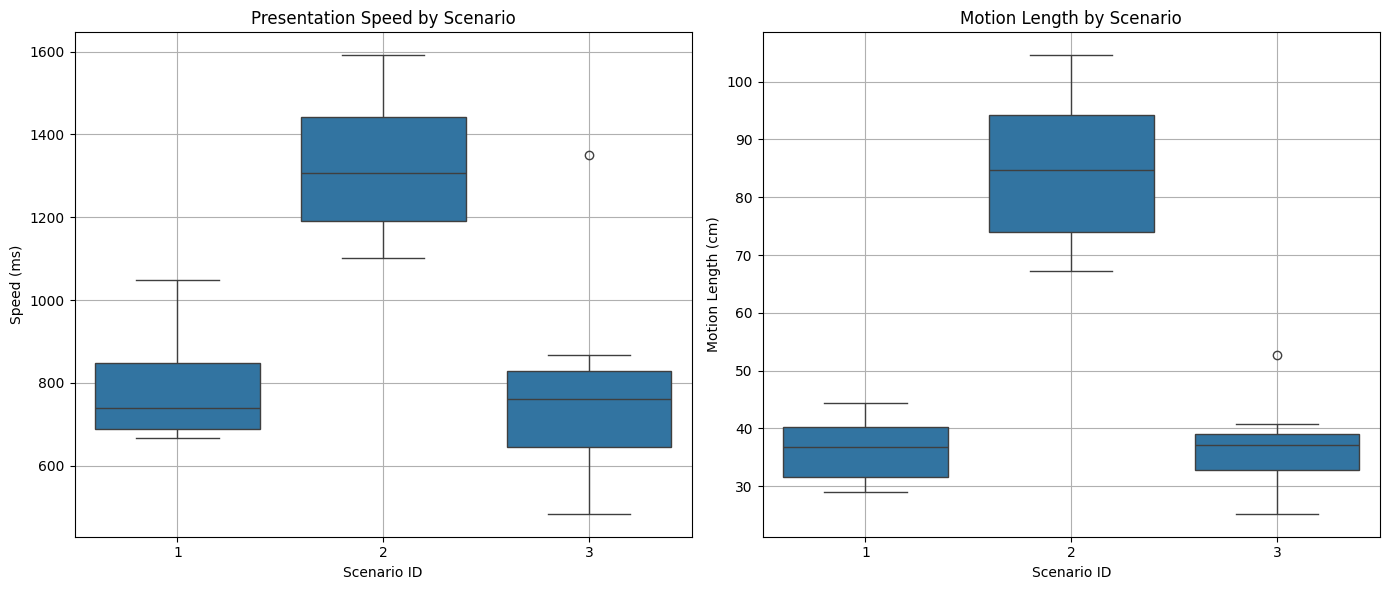

<Figure size 1200x700 with 0 Axes>

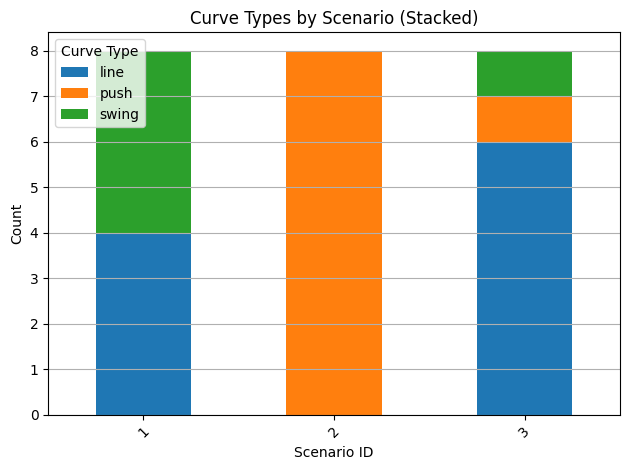

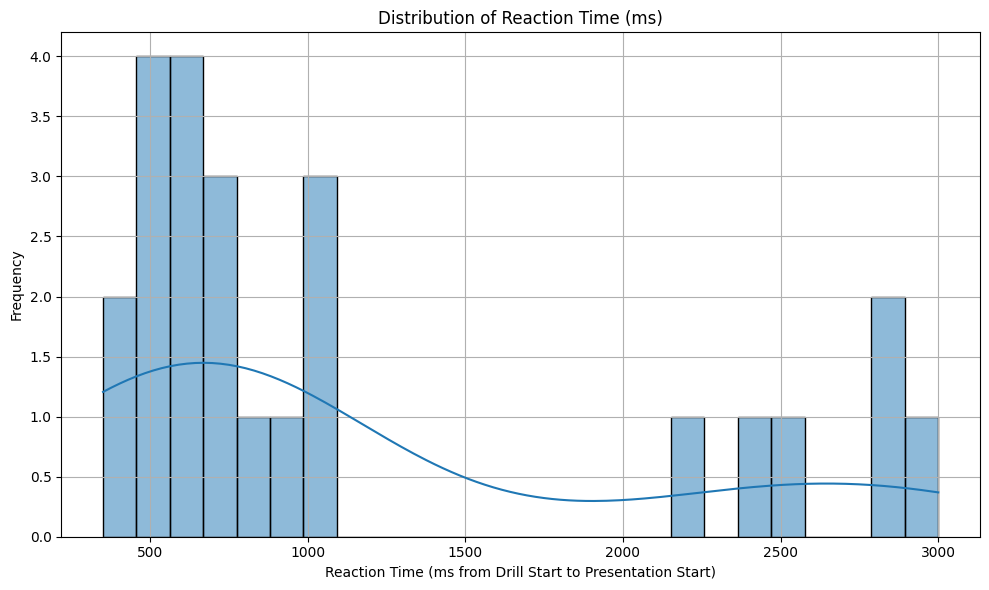

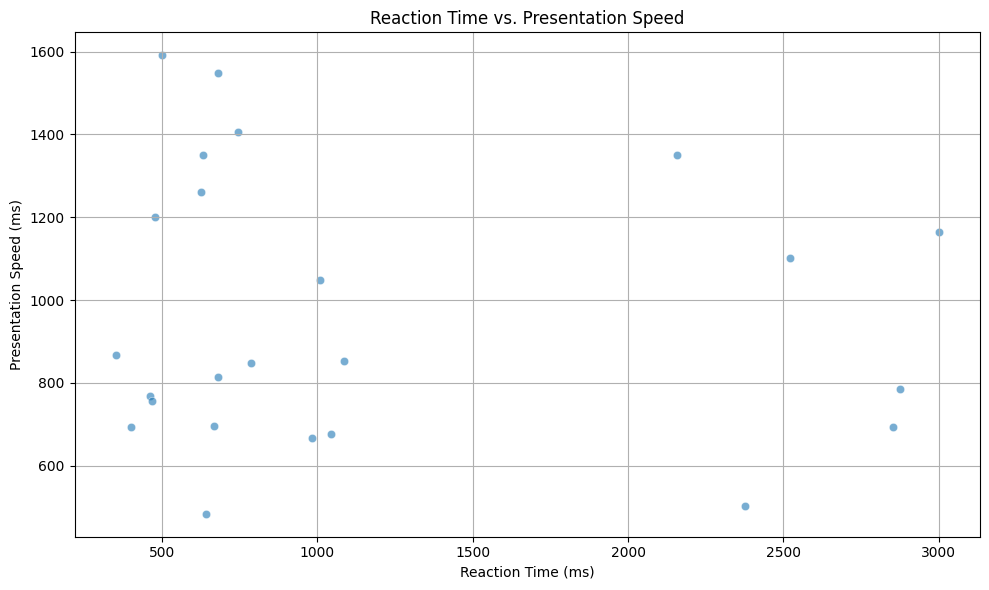

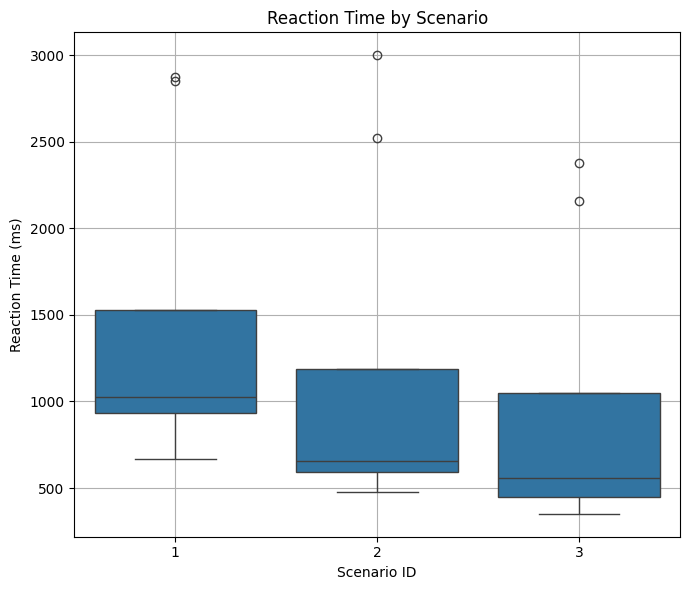

EDA plots generated and saved (if any).


In [69]:

if 'final_results_df' in locals() and not final_results_df.empty:
    perform_exploratory_analysis(final_results_df)
else:
    print("final_results_df is not defined or is empty. Skipping EDA.")